# Data Science Researh Methods Final Assignment

Felipe Martín CandNo: 260774

## Contents:
* [Introduction](#first-bullet)
* [Importing the data](#second-bullet) 
* [Data cleaning](#third-bullet)
* [Exploratory Data Analysis](#fourth-bullet)
* [Hypotesis](#fifth-bullet)
* [Model to predict Heart Rate](#six-bullet)
* [Model to classify activities](#seven-bullet)
* [Outcomes](#eight-bullet)
* [References](#nine-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>

The aim of this report is to develop an algorithm to obtain the amount of physical activity and type of activity carried out by an individual.

We have 9 individuals who were fitted with an IMU sensor on their ankle, hand and chest to take measurements while performing different physical exertion activities. Each IMU sensor measures the following parameters:

- 1 temperature measurement (°C)

- 3 measurements 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit

- 3 measurements 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit* 3 measurements 3D-gyroscope data (ms-2), scale: ±6g, resolution: 13-bit

- 3 measurements 3D-gyroscope data (rad/s)

- 3 measurements 3D-magnetometer data (μT)

- 4 orientation measurements (invalid in this data collection)

In addition, the heart rate of the individual is measured.

To address the problem we separate it into two main parts. First, a supervised machine learning model to predict heart rate values, as this indicator is the most appropriate to measure the state and time that an individual has been doing physical activity. Here we use a linear regression model and a decision tree model called random forest, originally a classification model but adapted to perform regression.

The second part will consist of a model to predict activities, so it must be a classification model. For this case we chose K-means clustering with PCA reduced data, K-Nearest Neighbors and decision tree model. It should be noted that although the first K-means model is an unsupervised machine learning model not so suitable for this case we wanted to test it anyway to compare its behaviour with supervised learning classification models.

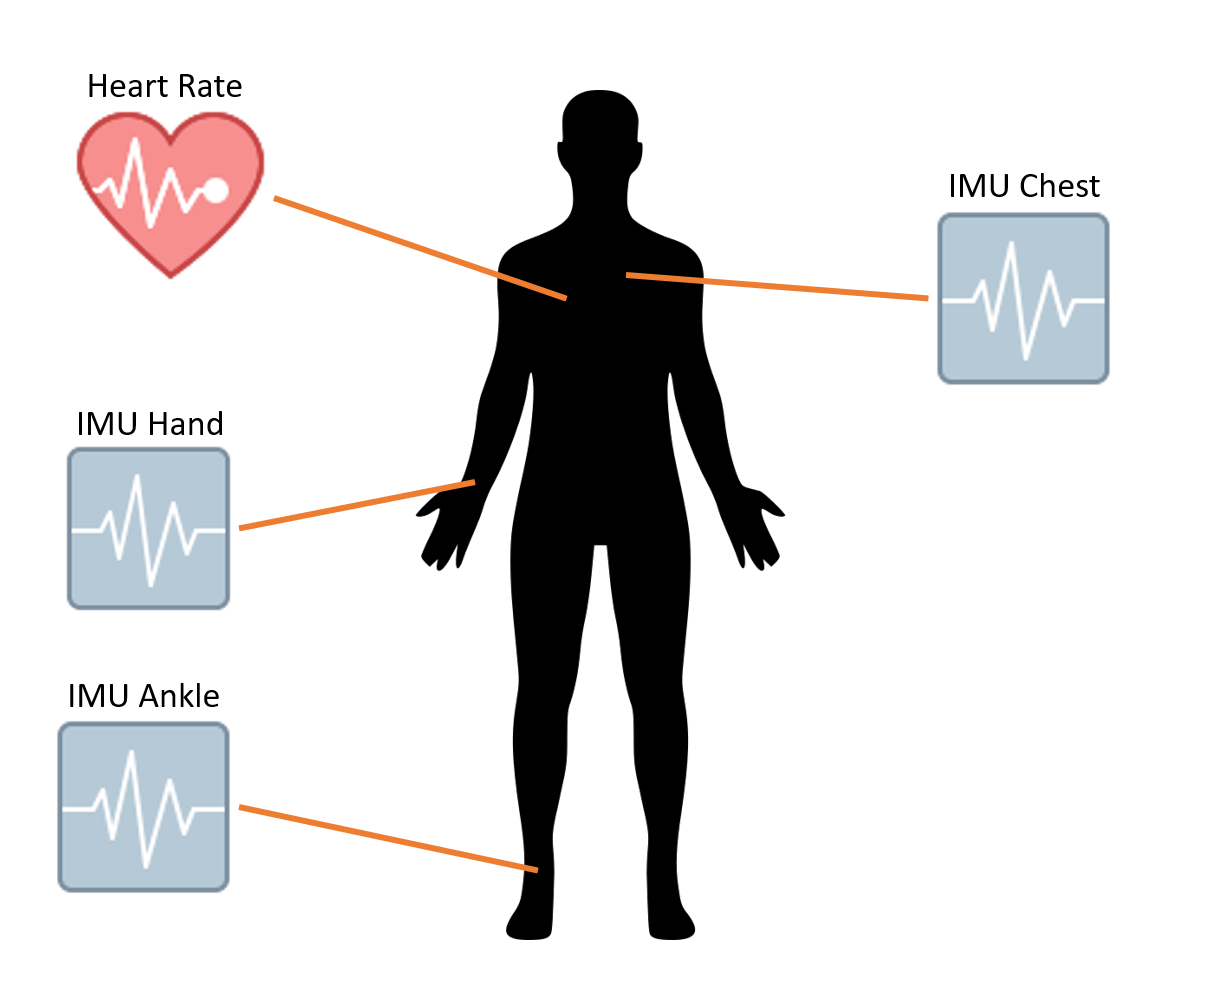

# Importing the data <a class="anchor" id="second-bullet"></a>

In [110]:
#Libraries used in the report.

import numpy as np  
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import scipy.stats as stats #For the correlation matrix and calculation of the p-value
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold #Importamos la libreria KFold para implementar la validación cruzada
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import v_measure_score
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from numpy import mean
from numpy import std
from sklearn import tree



We create a dimension table with the information for each subject.

In [3]:
elementos= { 
"Subject_ID": [101,102,103,104,105,106,107,108,109],
"Sex":["Male","Female","Male","Male","Male","Male","Male","Male","Male"],
"Age (years)":[27,25, 31, 24,26,26,23,32,31],
"Height (cm)":[182,169,187,194,180,183,173,179,168],
"Weight (kg)":[83,78,92,95,73,69,86,87,65],
"Resting HR (bpm)":[75,74,68,58,70,60,60,66,54],
"Max HR (bpm)":[193,195,189,196,194,194,197,188,189],
"Dominant hand":["right","right","right","right","right","right","right","left","right"]
}

DimSubject=pd.DataFrame(elementos)

In [4]:
DimSubject

Subject_ID     Sex  Age (years)  Height (cm)  Weight (kg)  \
0         101    Male           27          182           83   
1         102  Female           25          169           78   
2         103    Male           31          187           92   
3         104    Male           24          194           95   
4         105    Male           26          180           73   
5         106    Male           26          183           69   
6         107    Male           23          173           86   
7         108    Male           32          179           87   
8         109    Male           31          168           65   

   Resting HR (bpm)  Max HR (bpm) Dominant hand  
0                75           193         right  
1                74           195         right  
2                68           189         right  
3                58           196         right  
4                70           194         right  
5                60           194         right  
6                60           197         right  
7                66           188          left  
8                54           189         right

We create a dimension table with the information of each activity. This table will allow us to add the name of the activity and the intensity (low, medium, high) to our main data table, making a crosswalk through the activityID.

In [5]:
elementos= { 
"activityID": [1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24,0],
"activity":["lying","sitting","standing","walking","running","cycling","Nordic walking","watching TV","computer work","car driving","ascending stairs","descending stairs","vacuum cleaning","ironing","folding laundry","house cleaning","playing soccer","rope jumping","other (transient activities)"],
"intensity":["low","low","low","medium","high","medium","medium","-","-","-","medium","medium","low","low","-","-","-","high","-"]   
}

DimActivity=pd.DataFrame(elementos)
                   


In [6]:
DimActivity

activityID                      activity intensity
0            1                         lying       low
1            2                       sitting       low
2            3                      standing       low
3            4                       walking    medium
4            5                       running      high
5            6                       cycling    medium
6            7                Nordic walking    medium
7            9                   watching TV         -
8           10                 computer work         -
9           11                   car driving         -
10          12              ascending stairs    medium
11          13             descending stairs    medium
12          16               vacuum cleaning       low
13          17                       ironing       low
14          18               folding laundry         -
15          19                house cleaning         -
16          20                playing soccer         -
17          24                  rope jumping      high
18           0  other (transient activities)         -

Next, we create our main table from the .dat files of each subject. The table is created from an iterative process (with a for) that runs through each document and stores it in a pandas dataframe.

In [7]:
import pandas as pd

files=['subject101','subject102','subject103','subject104','subject105','subject106','subject107','subject108','subject109']

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

Additional_Columns=['Subject_ID']

columnsname = colNames + IMUhand + IMUchest + IMUankle + Additional_Columns #all columns in one list
 
for i in files:
    locals()["df"+"_"+str(i)] = pd.read_table(str(i)+".dat", 
                     header=None,
                     sep = "\s+",
                     #columns=columnsname
                    )
    locals()["df"+"_"+str(i)][54]=i[-3::]

In [8]:
frames=[df_subject101,df_subject102,df_subject103,df_subject104,df_subject105,df_subject106,df_subject107,df_subject108,df_subject109]

#this merges all the frames (for each subject) into a single frame
df_full = pd.concat(frames)

df_full.columns = columnsname

Here we perform an inner join between the main table and the activity dimension table, to add the activity and intentisy columns to our main table.

In [9]:
df_full=pd.merge(df_full,DimActivity, on='activityID', how='inner')

We display the table:

In [10]:
df_full.head()

timestamp  activityID  heartrate  handTemperature  handAcc16_1  \
0       8.38           0      104.0             30.0      2.37223   
1       8.39           0        NaN             30.0      2.18837   
2       8.40           0        NaN             30.0      2.37357   
3       8.41           0        NaN             30.0      2.07473   
4       8.42           0        NaN             30.0      2.22936   

   handAcc16_2  handAcc16_3  handAcc6_1  handAcc6_2  handAcc6_3  ...  \
0      8.60074      3.51048     2.43954     8.76165     3.35465  ...   
1      8.56560      3.66179     2.39494     8.55081     3.64207  ...   
2      8.60107      3.54898     2.30514     8.53644     3.73280  ...   
3      8.52853      3.66021     2.33528     8.53622     3.73277  ...   
4      8.83122      3.70000     2.23055     8.59741     3.76295  ...   

   ankleMagne1  ankleMagne2  ankleMagne3  ankleOrientation1  \
0     -61.1888     -38.9599     -58.1438                1.0   
1     -59.8479     -38.8919     -58.5253                1.0   
2     -60.7361     -39.4138     -58.3999                1.0   
3     -60.4091     -38.7635     -58.3956                1.0   
4     -61.5199     -39.3879     -58.2694                1.0   

   ankleOrientation2  ankleOrientation3  ankleOrientation4  Subject_ID  \
0                0.0                0.0                0.0         101   
1                0.0                0.0                0.0         101   
2                0.0                0.0                0.0         101   
3                0.0                0.0                0.0         101   
4                0.0                0.0                0.0         101   

                       activity  intensity  
0  other (transient activities)          -  
1  other (transient activities)          -  
2  other (transient activities)          -  
3  other (transient activities)          -  
4  other (transient activities)          -  

[5 rows x 57 columns]

# Data cleaning <a class="anchor" id="third-bullet"></a>

We count the number of rows in each column and observe that for the most part, there is a good amount of data for each column, except for the heartrate column. This column contains too many null values and should be treated differently.

In [11]:
df_full.count()

timestamp            2872533
activityID           2872533
heartrate             262268
handTemperature      2859392
handAcc16_1          2859392
handAcc16_2          2859392
handAcc16_3          2859392
handAcc6_1           2859392
handAcc6_2           2859392
handAcc6_3           2859392
handGyro1            2859392
handGyro2            2859392
handGyro3            2859392
handMagne1           2859392
handMagne2           2859392
handMagne3           2859392
handOrientation1     2859392
handOrientation2     2859392
handOrientation3     2859392
handOrientation4     2859392
chestTemperature     2868970
chestAcc16_1         2868970
chestAcc16_2         2868970
chestAcc16_3         2868970
chestAcc6_1          2868970
chestAcc6_2          2868970
chestAcc6_3          2868970
chestGyro1           2868970
chestGyro2           2868970
chestGyro3           2868970
chestMagne1          2868970
chestMagne2          2868970
chestMagne3          2868970
chestOrientation1    2868970
chestOrientati

We remove NaN values from all columns except heartrate, as the number of Nan values in heartrate is too high, so it must be treated differently.

In [12]:
## removal of any NaN values across the dataset
df_full= df_full.dropna(subset=["timestamp", "activityID",'handTemperature', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4','chestTemperature', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4','ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'])
df_full.reset_index(drop = True, inplace = True)

To handle HeartRate Null values, we have two options, simply delete them or fill the empty values with an average - or with the value immediately below the empty value. We choose the latter option because if we delete the empty values we lose most of the data.


In [14]:
df_full['heartrate']=df_full.heartrate.ffill(axis = 0)

In [15]:
#number of rows per column 
df_full.count()

timestamp            2844868
activityID           2844868
heartrate            2844868
handTemperature      2844868
handAcc16_1          2844868
handAcc16_2          2844868
handAcc16_3          2844868
handAcc6_1           2844868
handAcc6_2           2844868
handAcc6_3           2844868
handGyro1            2844868
handGyro2            2844868
handGyro3            2844868
handMagne1           2844868
handMagne2           2844868
handMagne3           2844868
handOrientation1     2844868
handOrientation2     2844868
handOrientation3     2844868
handOrientation4     2844868
chestTemperature     2844868
chestAcc16_1         2844868
chestAcc16_2         2844868
chestAcc16_3         2844868
chestAcc6_1          2844868
chestAcc6_2          2844868
chestAcc6_3          2844868
chestGyro1           2844868
chestGyro2           2844868
chestGyro3           2844868
chestMagne1          2844868
chestMagne2          2844868
chestMagne3          2844868
chestOrientation1    2844868
chestOrientati

Here we eliminate activities classified as "other" or activityID = 0.

In [16]:
df_full = df_full[df_full.activityID != 0]

In [17]:
## checking if any null values exist in dataframe
df_full.isnull().sum()

timestamp            0
activityID           0
heartrate            0
handTemperature      0
handAcc16_1          0
handAcc16_2          0
handAcc16_3          0
handAcc6_1           0
handAcc6_2           0
handAcc6_3           0
handGyro1            0
handGyro2            0
handGyro3            0
handMagne1           0
handMagne2           0
handMagne3           0
handOrientation1     0
handOrientation2     0
handOrientation3     0
handOrientation4     0
chestTemperature     0
chestAcc16_1         0
chestAcc16_2         0
chestAcc16_3         0
chestAcc6_1          0
chestAcc6_2          0
chestAcc6_3          0
chestGyro1           0
chestGyro2           0
chestGyro3           0
chestMagne1          0
chestMagne2          0
chestMagne3          0
chestOrientation1    0
chestOrientation2    0
chestOrientation3    0
chestOrientation4    0
ankleTemperature     0
ankleAcc16_1         0
ankleAcc16_2         0
ankleAcc16_3         0
ankleAcc6_1          0
ankleAcc6_2          0
ankleAcc6_3

# Exploratory Data Analysis <a class="anchor" id="fourth-bullet"></a>
 

In the following, we will perform an exploratory analysis of the data in order to find trends and patterns that are not evident. We first analyse the heart rate, then the temperature and finally we will see if there is a correlation between all the variables with the heart rate.

## Heart Rate

First, we plot an average heart rate over time (timestamp) considering all subjects.

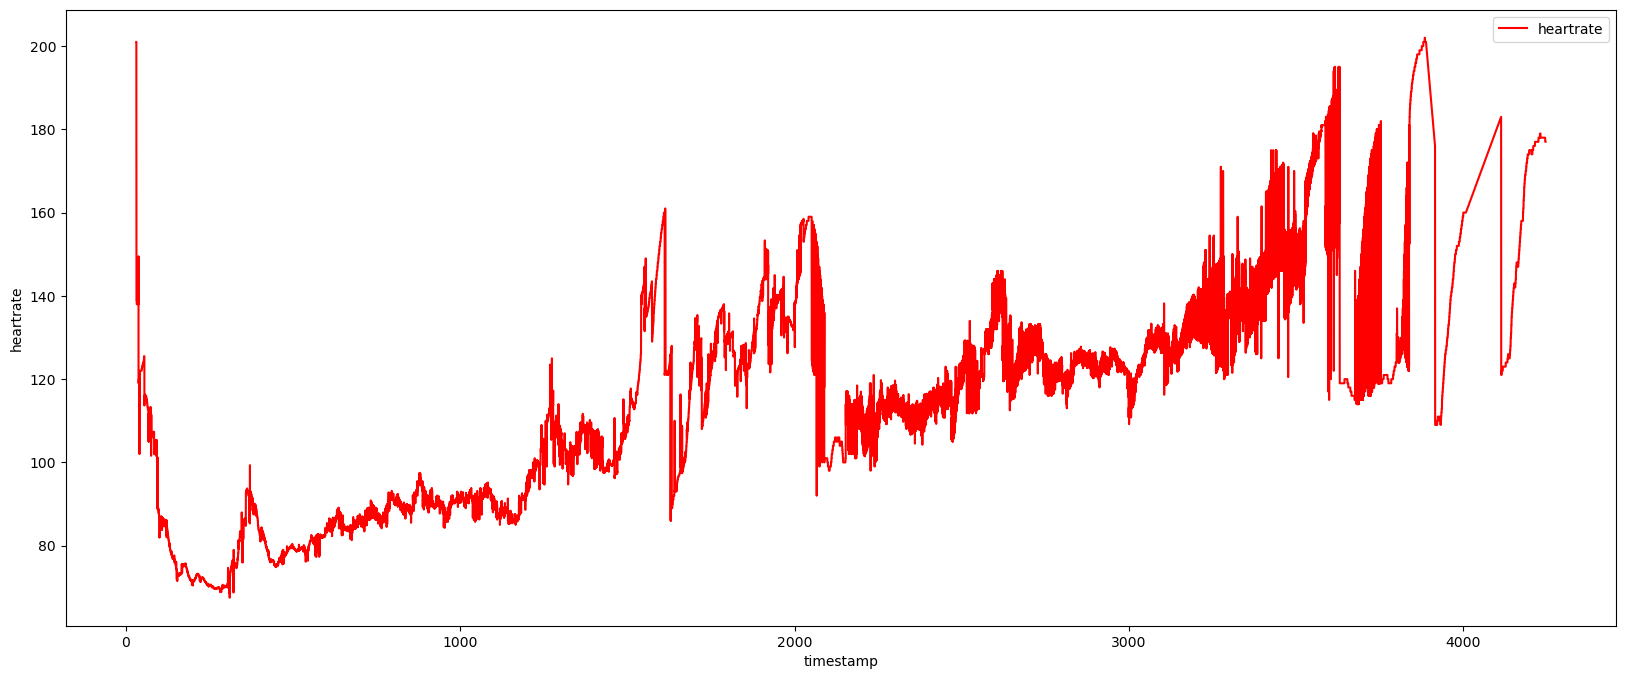

In [18]:
fig,axs = plt.subplots(ncols=1, figsize=(20,8))
sns.lineplot( x = "timestamp", y = "heartrate", data = df_full,ci=None,label='heartrate',color='red')

plt.show()

We then plot the heart rate mean by subject and activity. 

In [19]:
result = df_full.groupby(['timestamp','Subject_ID','activity']).aggregate({'heartrate':'max'})
result =result.groupby(['Subject_ID','activity']).aggregate({'heartrate':'mean'}).apply(lambda x: x.sort_values(ascending=True))
result2 =result.groupby(['activity']).aggregate({'heartrate':'mean'}).apply(lambda x: x.sort_values(ascending=True))


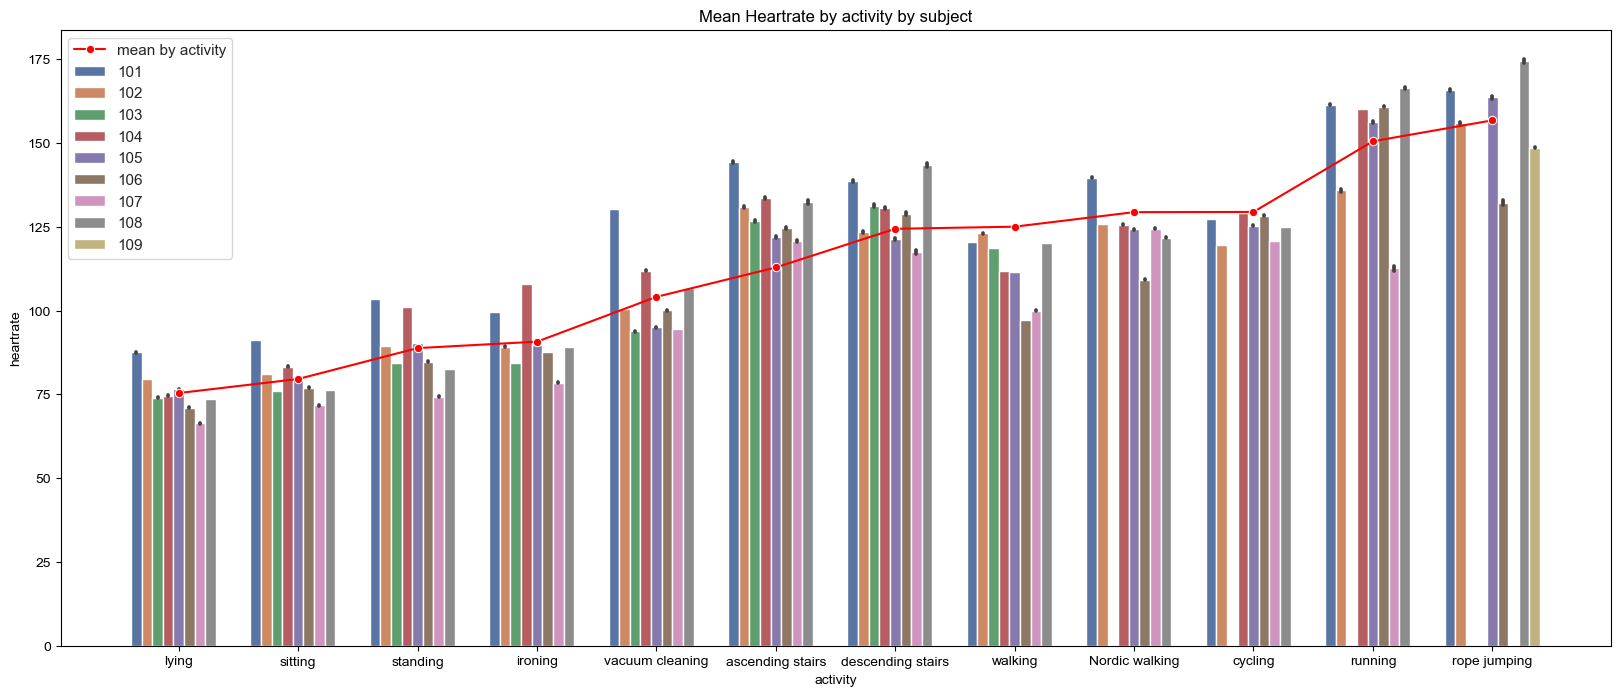

In [20]:
fig,axs = plt.subplots(ncols=1, figsize=(20,8))
sns.set_theme(style="whitegrid")
sns.barplot(data=df_full, x="activity", y="heartrate", hue="Subject_ID")
sns.lineplot( x = "activity", y = "heartrate", data = result2,ci=None,color='red',label='mean by activity',marker="o")
plt.title("Mean Heartrate by activity by subject")
plt.show()

We observe that there is a clear clustering of the activities and this can be seen by the fact that the slope of the trend (mean by activity) has 3 sharp changes. The first group is lying, sitting, standing, ironing and vacuum cleaning, the second group, ascending stairs, descending stairs, walking, nordic walking and cycling, and the third group, running and rope jumping.

We also observe that the subject with the highest average heart rate in most activities is subject 101, followed by subject 104.

Next, we again plotted the average heart rate graph over time (timestamp) but categorised by the intensity of activity (low, medium, high) obtained from the analysis of the previous graph.

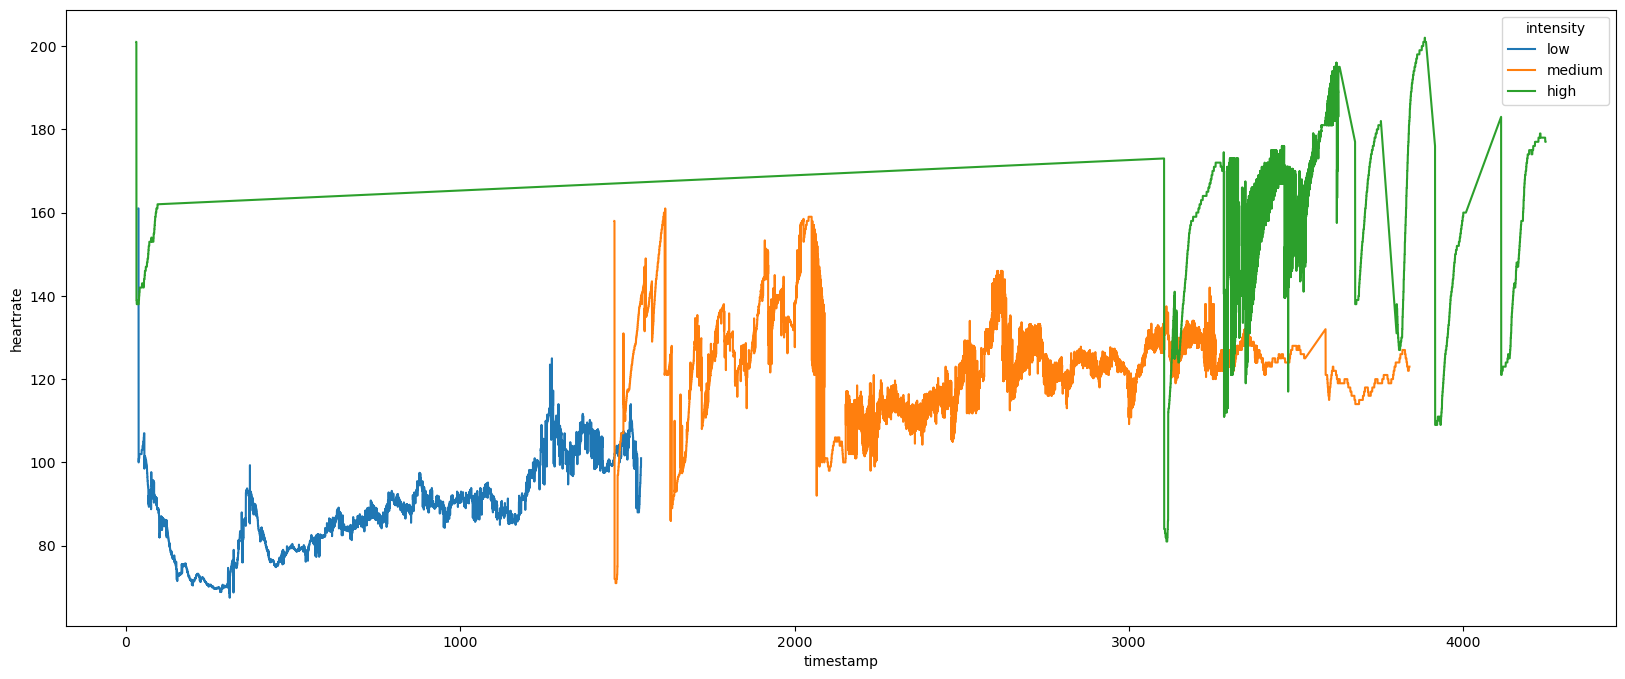

In [200]:
fig,axs = plt.subplots(ncols=1, figsize=(20,8))
sns.lineplot( x = "timestamp", y = "heartrate", data = df_full,ci=None,color='red',hue='intensity')
plt.show()

We observe that there is a clear tendency for the heart rate to increase with the level of intensity. That is, the higher the intensity, the higher the heart rate.

Without considering outliers, for low intensity, the heart rate moves between 60 and 120, for medium intensity, between 80 and 160, and for high intensity, between 100 and 200.

### Boxplots and histograms analysis

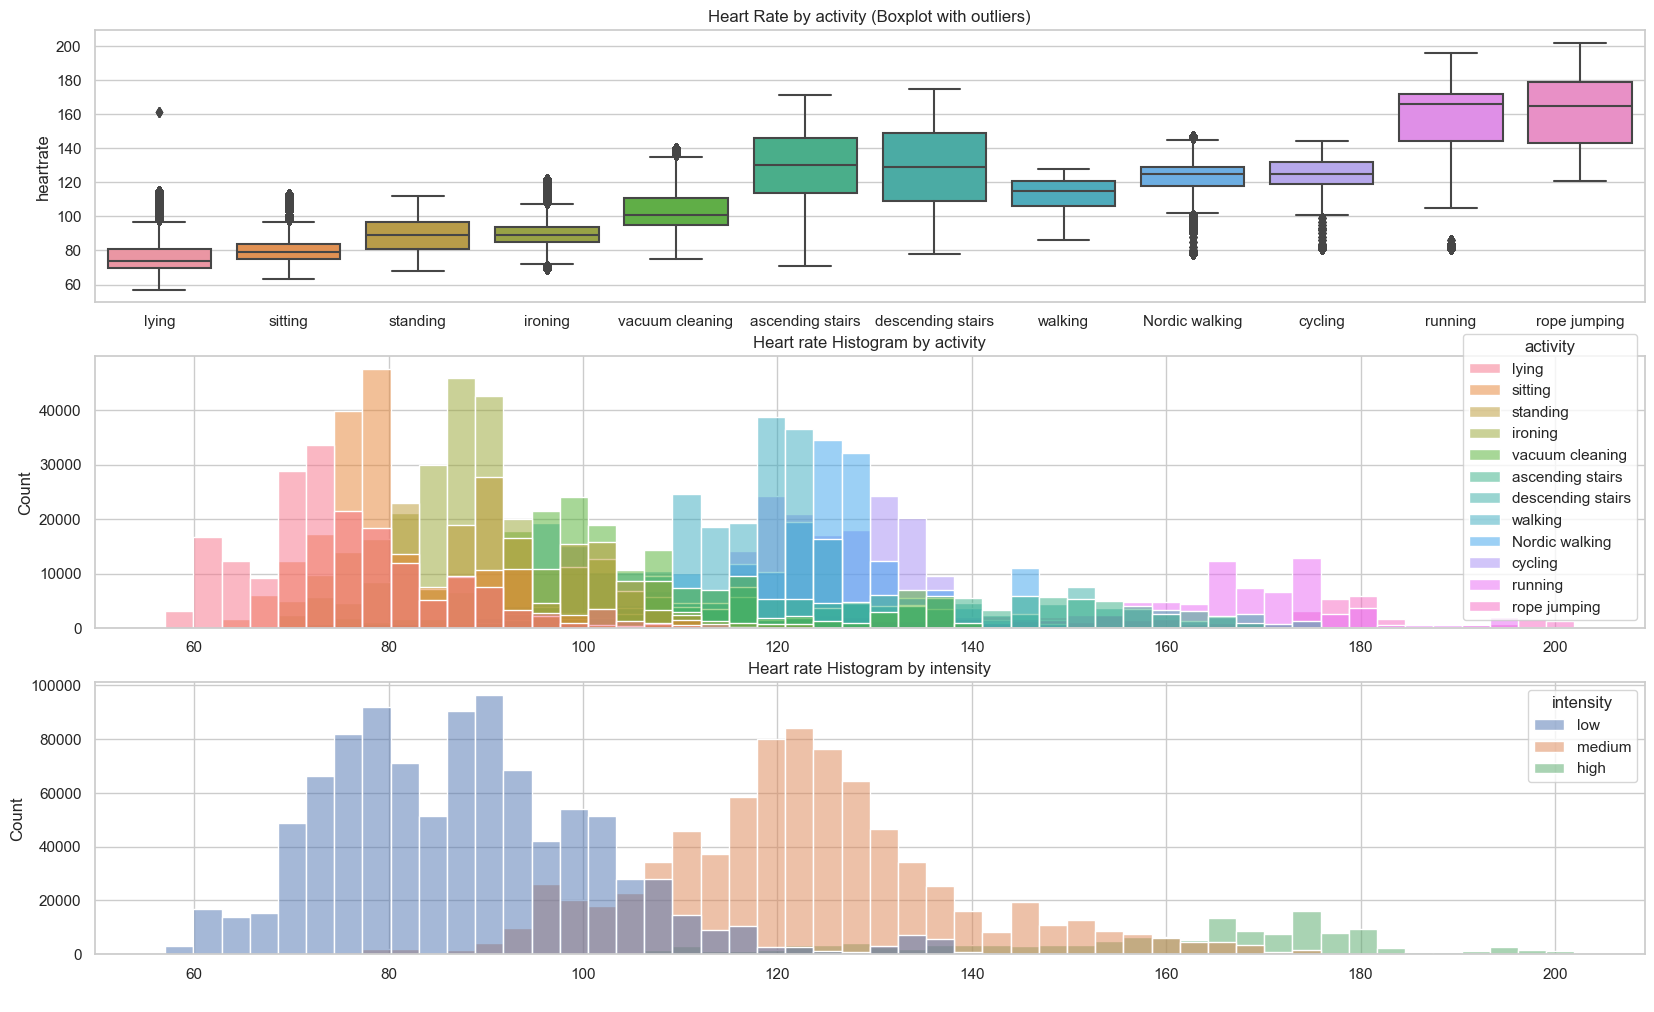

In [32]:
fig,axs = plt.subplots(nrows=3, figsize=(20,12))
sns.boxplot(x="activity", y="heartrate", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="heartrate",bins=50,hue='activity',ax=axs[1]) 
sns.histplot(df_full, x="heartrate",bins=50,hue='intensity',ax=axs[2]) 
axs[0].set_title('Heart Rate by activity (Boxplot with outliers)')
axs[0].set_xlabel(' ')
axs[1].set_title('Heart rate Histogram by activity')  
axs[1].set_title('Heart rate Histogram by activity')  
axs[1].set_xlabel(' ')
axs[2].set_title('Heart rate Histogram by intensity')  
axs[2].set_xlabel(' ')
plt.show()

The boxplots show that in the case of low intensity activities the data has little dispersion and the average is between 60 and 100 bpm. In the medium intensity activities, ascending stairs and descending stairs have a higher dispersion than the rest of the activities and the average in this category is between 100 and 140 bpm. Finally, in the high intensity category, we also see a higher dispersion than the rest of the activities and an average value between 160 and 170 bpm.

The histograms show that the largest amount of data is concentrated in the 60-120 bpm range, and a smaller amount in the 120-180 bpm range.


## Temperature

Now we plot an average temperature by subject by body part.

In [53]:
df1=df_full[['Subject_ID','handTemperature','activity']]
df1=df1.rename({'handTemperature': 'temperature'}, axis=1)
df1['bodyPart']='hand'

df2=df_full[['Subject_ID','chestTemperature','activity']]
df2=df2.rename({'chestTemperature': 'temperature'}, axis=1)
df2['bodyPart']='chest'

df3=df_full[['Subject_ID','ankleTemperature','activity']]
df3=df3.rename({'ankleTemperature': 'temperature'}, axis=1)
df3['bodyPart']='ankle'

concatTemperature = pd.concat([df1,df2,df3 ], ignore_index=True, sort=False)

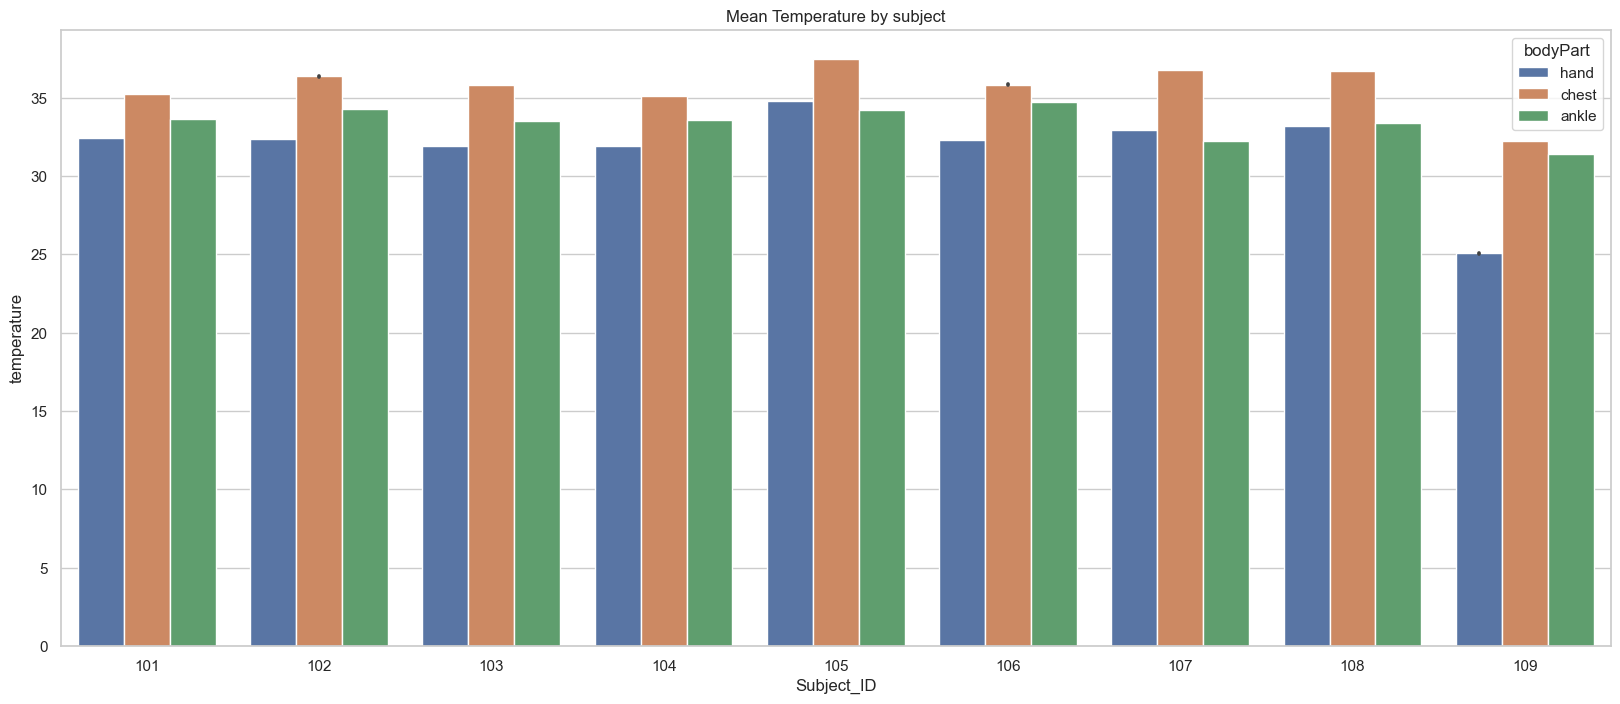

In [54]:
fig,axs = plt.subplots(ncols=1, figsize=(20,8))

sns.set_theme(style="whitegrid")
sns.barplot(x='Subject_ID', y="temperature", data=concatTemperature,hue='bodyPart')

plt.title("Mean Temperature by subject")
#fig.tight_layout()
plt.show()

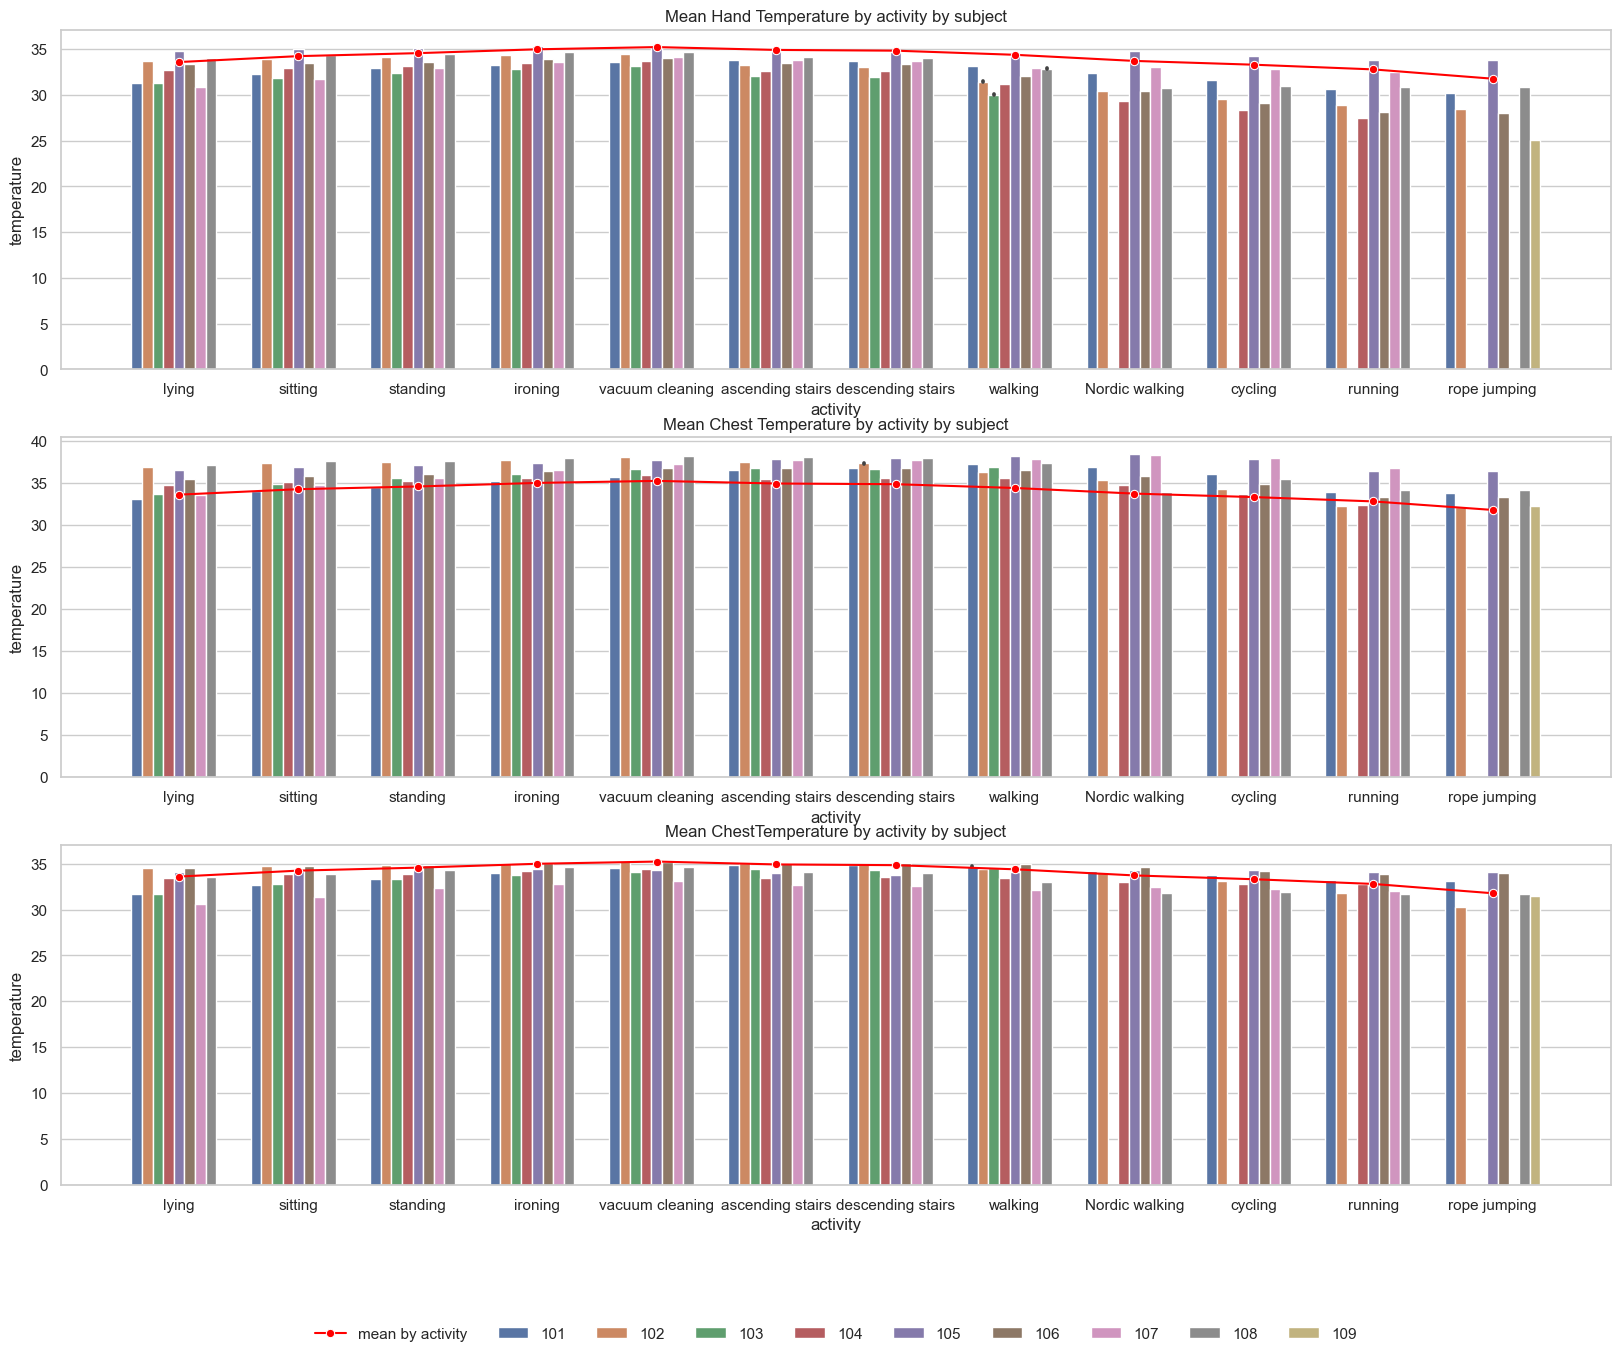

In [215]:
fig,axs = plt.subplots(nrows=3, figsize=(20,15))

sns.set_theme(style="whitegrid")

sns.barplot(x='activity', y="temperature", data=concatTemperature[(concatTemperature.bodyPart == "hand")],hue='Subject_ID',ax=axs[0])
sns.lineplot( x = "activity", y = "temperature", data = concatTemperature,ci=None,color='red',label='mean by activity',marker="o",ax=axs[0])
sns.move_legend(axs[0], "lower center",bbox_to_anchor=(.5, -0.5), ncol=10, title=None, frameon=False)

sns.barplot(x='activity', y="temperature", data=concatTemperature[(concatTemperature.bodyPart == "chest")],hue='Subject_ID',ax=axs[1])
sns.lineplot( x = "activity", y = "temperature", data = concatTemperature,ci=None,color='red',label='mean by activity',marker="o",ax=axs[1])
sns.move_legend(axs[1], "lower center", bbox_to_anchor=(.5, -0.5), ncol=10, title=None, frameon=False)

sns.barplot(x='activity', y="temperature", data=concatTemperature[(concatTemperature.bodyPart == "ankle")],hue='Subject_ID',ax=axs[2])
sns.lineplot( x = "activity", y = "temperature", data = concatTemperature,ci=None,color='red',label='mean by activity',marker="o",ax=axs[2])
sns.move_legend(axs[2], "lower center", bbox_to_anchor=(.5, -0.5), ncol=10, title=None, frameon=False)

axs[0].set_title('Mean Hand Temperature by activity by subject')
axs[1].set_title('Mean Chest Temperature by activity by subject')           
axs[2].set_title('Mean ChestTemperature by activity by subject')  

plt.show()

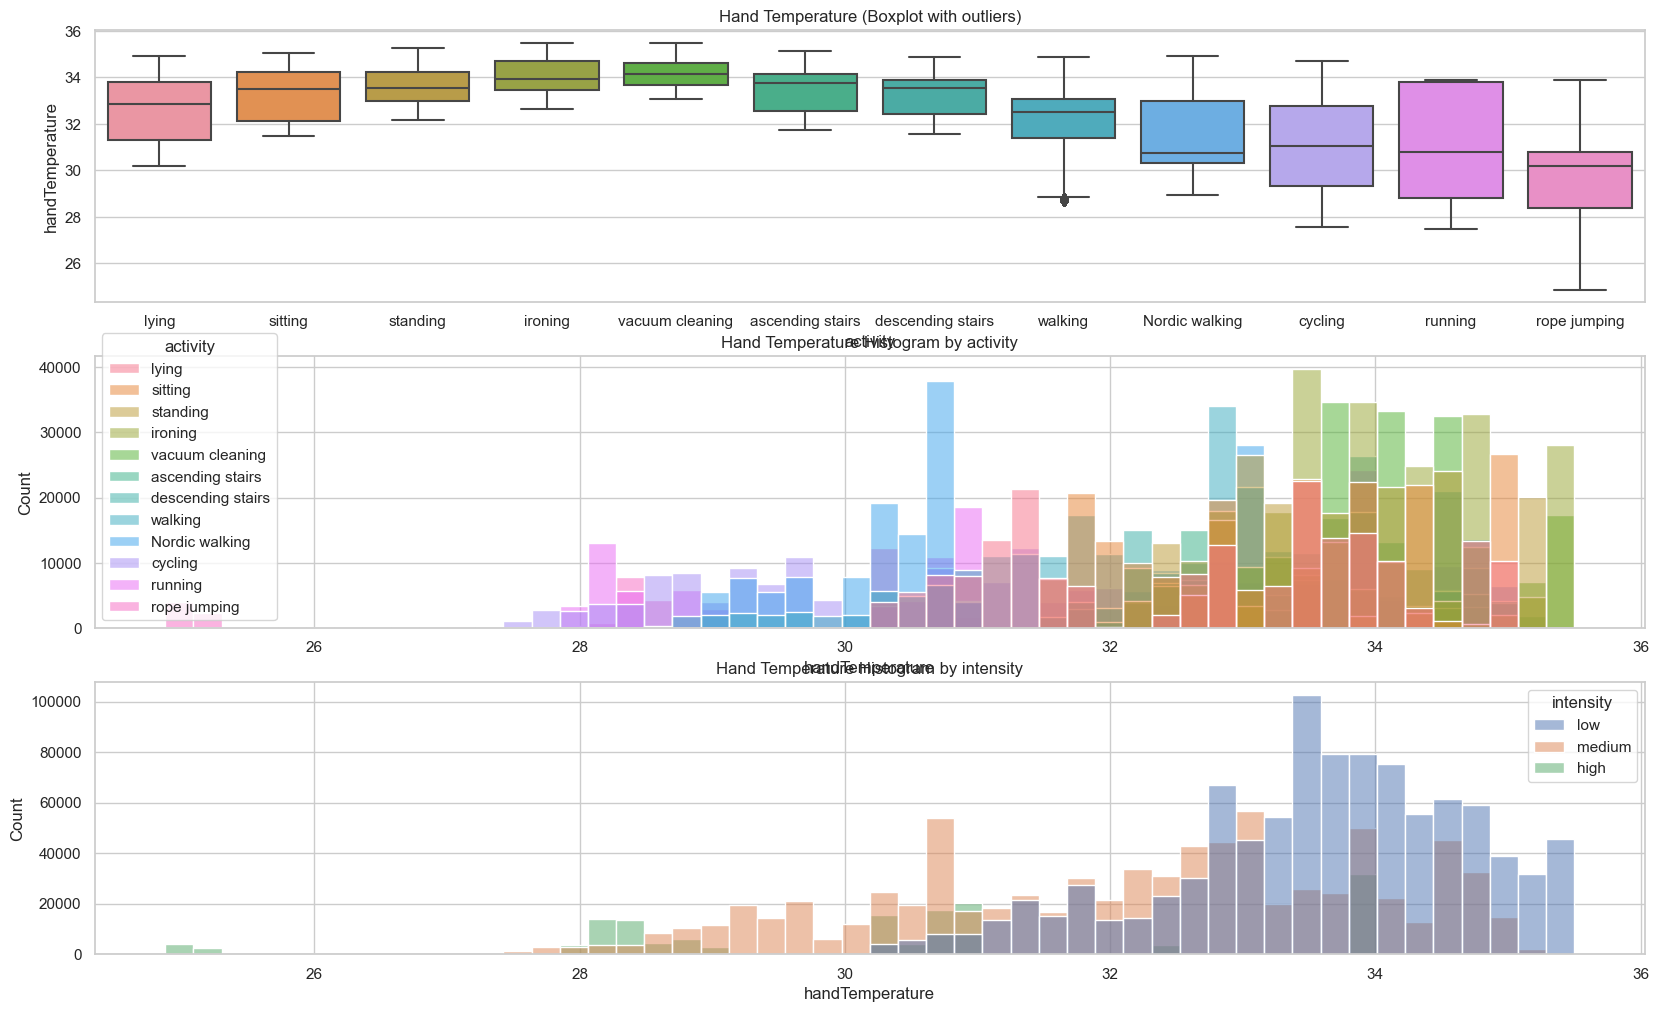

In [216]:
fig,axs = plt.subplots(nrows=3, figsize=(20,12))
sns.boxplot(x="activity", y="handTemperature", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="handTemperature",bins=50,hue='activity',ax=axs[1]) 
sns.histplot(df_full, x="handTemperature",bins=50,hue='intensity',ax=axs[2]) 
axs[0].set_title('Hand Temperature (Boxplot with outliers)')
axs[1].set_title('Hand Temperature Histogram by activity')  
axs[2].set_title('Hand Temperature Histogram by intensity')  
plt.show()

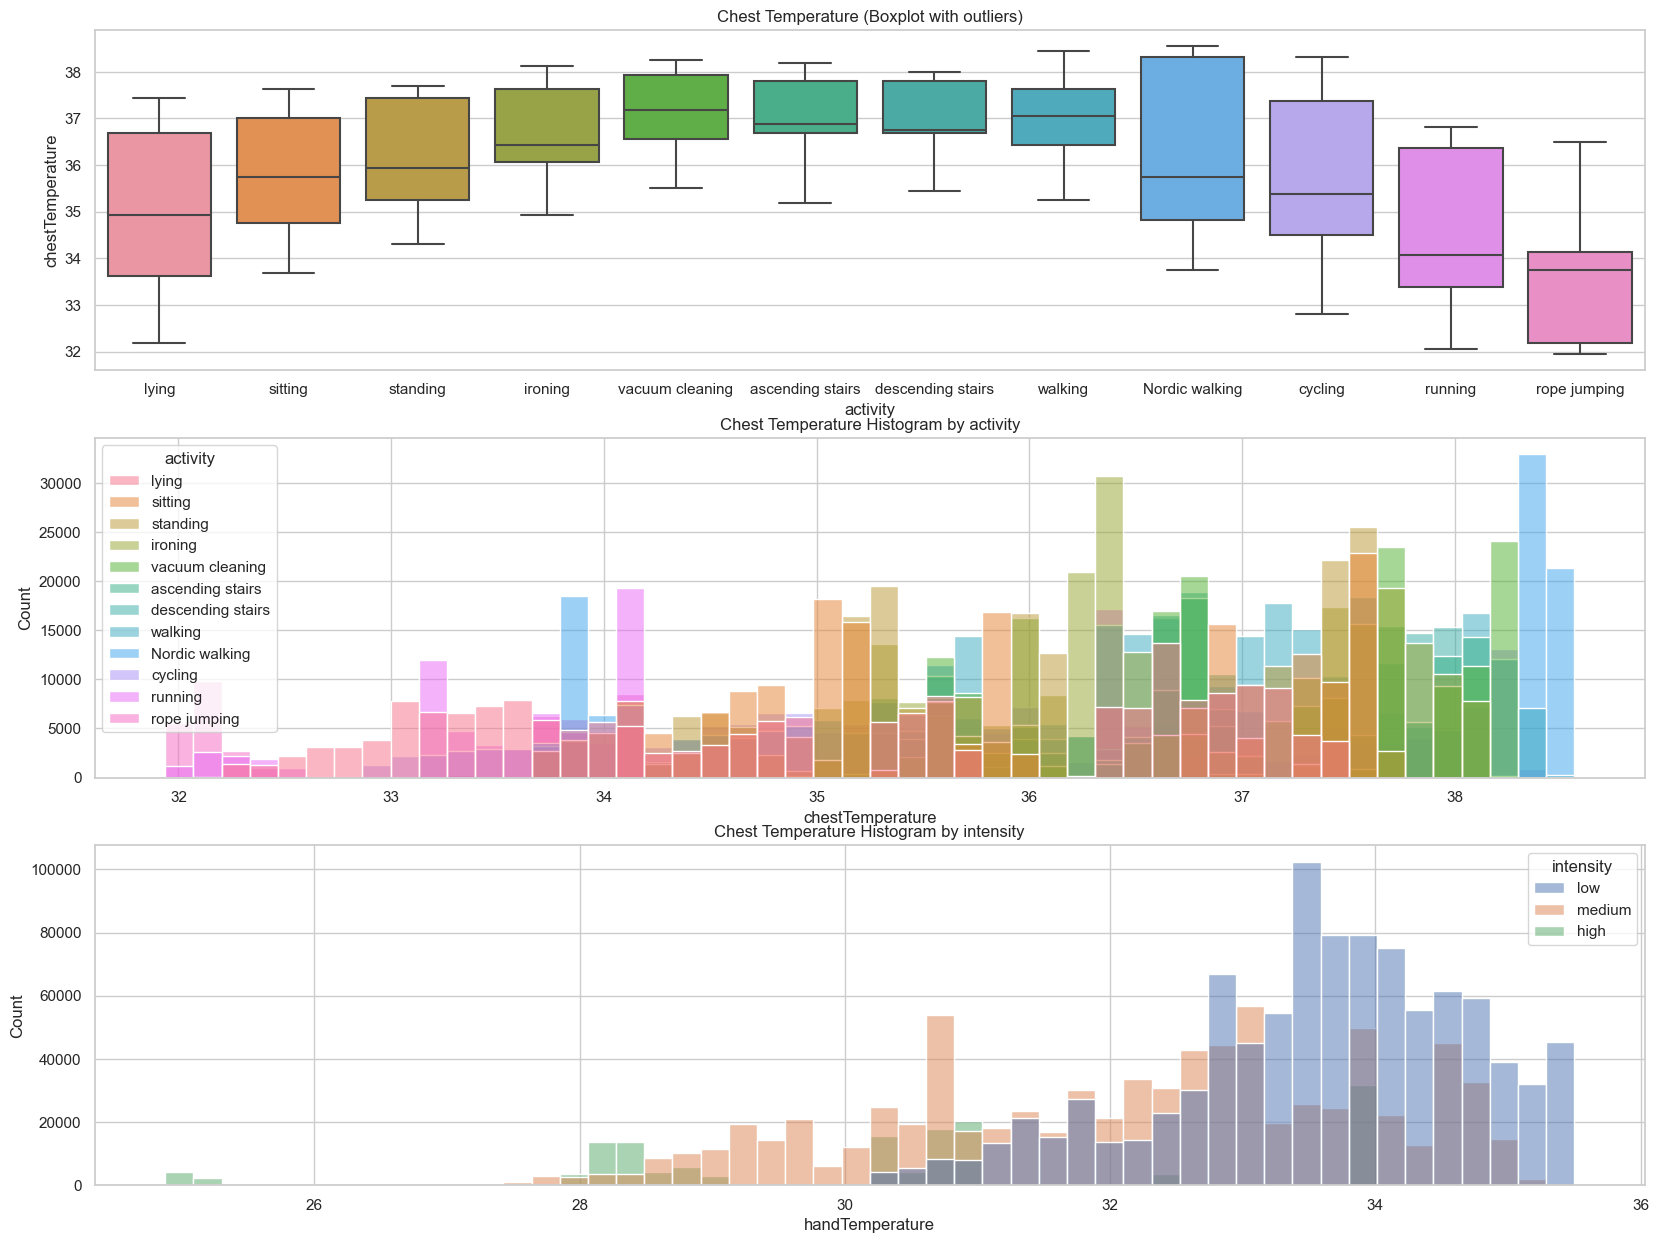

In [217]:
fig,axs = plt.subplots(nrows=3, figsize=(20,15))
sns.boxplot(x="activity", y="chestTemperature", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="chestTemperature",bins=50,hue='activity',ax=axs[1])
sns.histplot(df_full, x="handTemperature",bins=50,hue='intensity',ax=axs[2]) 
axs[0].set_title('Chest Temperature (Boxplot with outliers)')
axs[1].set_title('Chest Temperature Histogram by activity')  
axs[2].set_title('Chest Temperature Histogram by intensity')                         
plt.show()

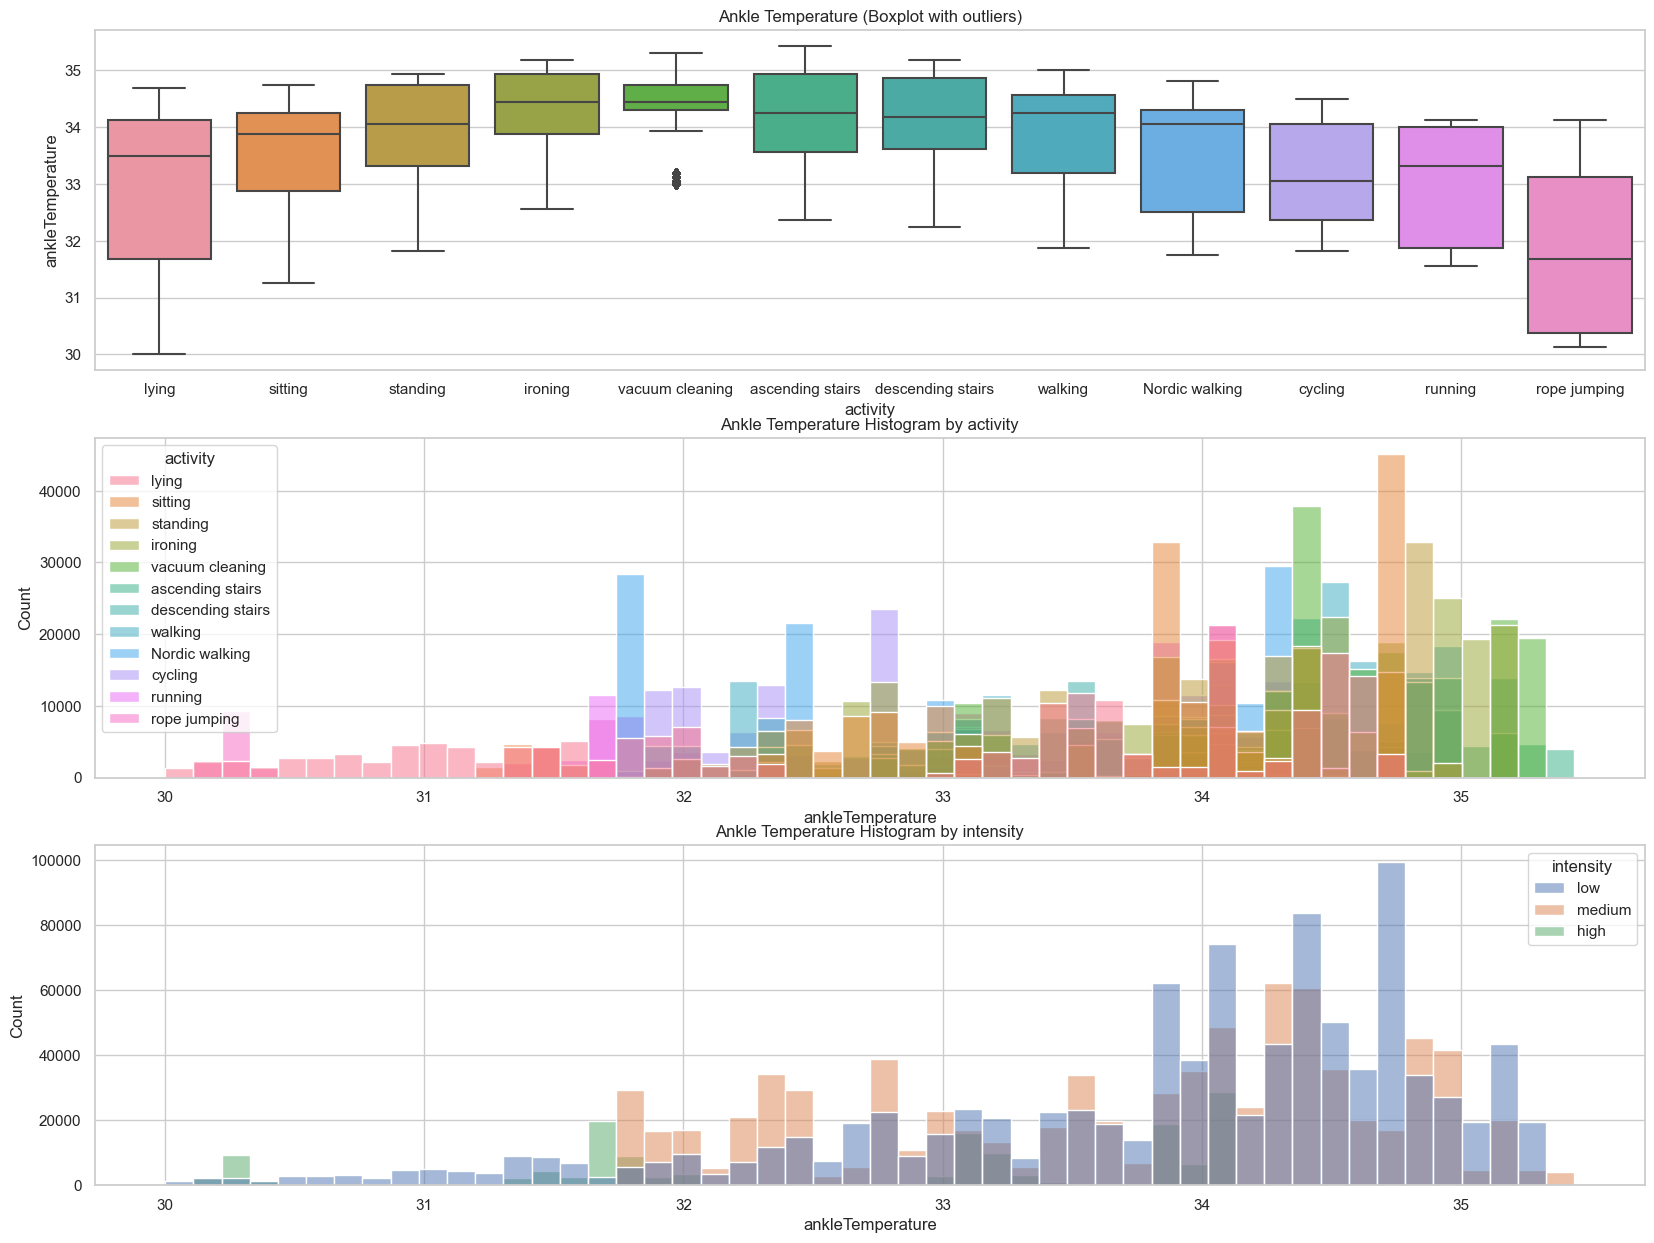

In [218]:
fig,axs = plt.subplots(nrows=3, figsize=(20,15))
sns.boxplot(x="activity", y="ankleTemperature", data=df_full,showfliers=True,ax=axs[0])
sns.histplot(df_full, x="ankleTemperature",bins=50,hue='activity',ax=axs[1]) 
sns.histplot(df_full, x="ankleTemperature",bins=50,hue='intensity',ax=axs[2]) 

axs[0].set_title('Ankle Temperature (Boxplot with outliers)')
axs[1].set_title('Ankle Temperature Histogram by activity')  
axs[2].set_title('Ankle Temperature Histogram by intensity')                              
plt.show()

The average temperatures on each body part are similar for each subject, with the exception of subject 109, whose average hand temperature drops to 25, chest to 32 and ankle to 31 degrees Celsius. This may be due to a reading error.

The graphs of mean temperature per subject per activity show that the mean temperature is lowest in low intensity activities, then rises in medium intensity activities, and finally, falls again in high intensity activities. This can be explained by the fact that high intensity activities activate the body's natural system to regulate temperature through perspiration.

The boxplot graphs show that at low intensity activities there is a considerable dispersion of temperature, at medium intensity the dispersion decreases and the data becomes more concentrated and finally, at high intensity, a high dispersion of data is observed.
The highest mean values in all intensity categories are found in the chest measurements. The histograms show that the data are concentrated to the right, between 32 and 35 degrees Celsius.

## Correlation matrix

The correlation between the variables will allow us to identify which variables best explain the heart rate, which will help us to create our first heart rate prediction model.

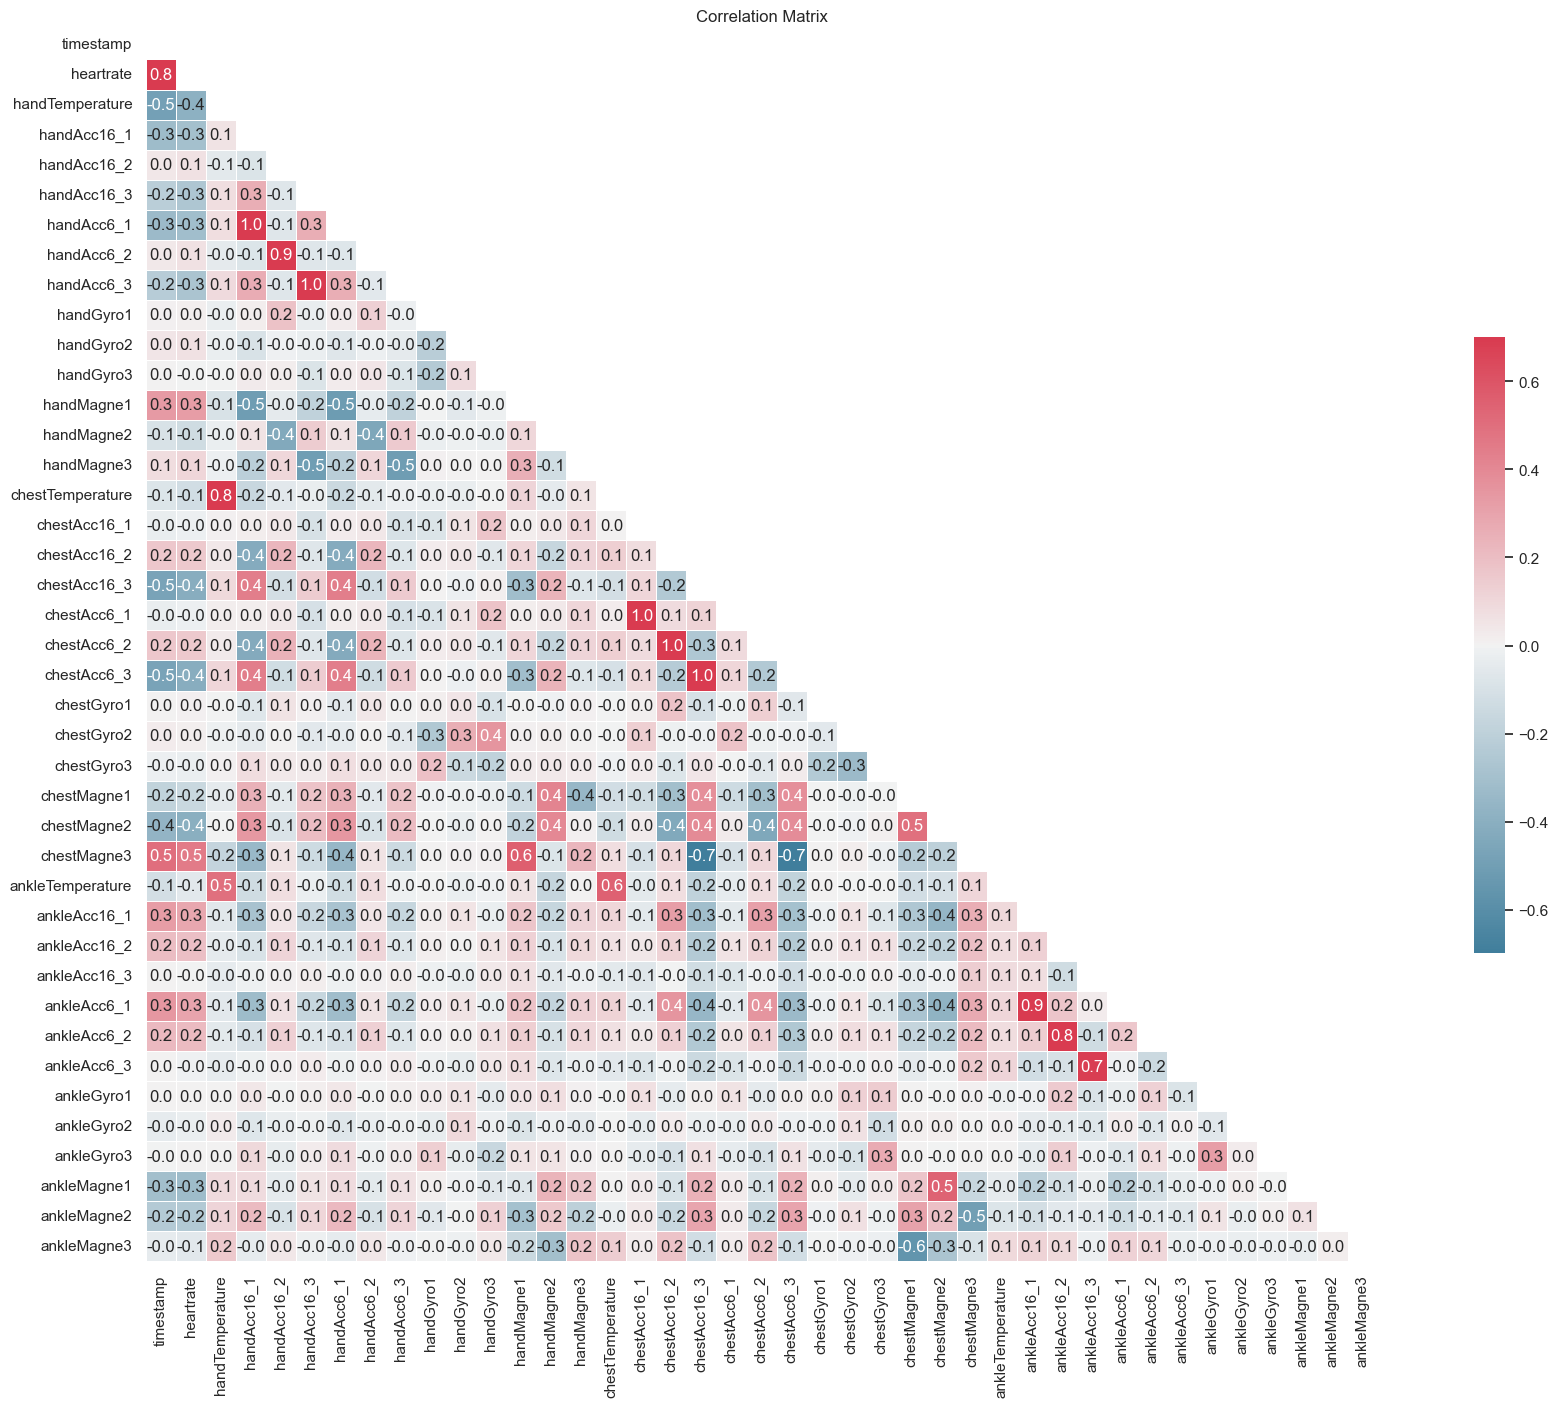

In [34]:
corr=df_full[['timestamp','heartrate','handTemperature','handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
                   'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
             'chestTemperature',
                   'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
             'ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 16))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 8, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot = True, fmt='.1f')
#sns.set(font_scale=1.5)
plt.title("Correlation Matrix")
plt.show()

#### From the correlation matrix we observe the following.

- There is a high positive correlation of 0.5 between heart rate and the variable chest Magnetic 3.

- There is a medium negative correlation of 0.4 between heart rate and hand temperature.
- There is a medium negative correlation of 0.4 between heart rate and chestAcc16 3.
- There is a medium negative correlation of 0.4 between heart rate and the variable chestAcc6 3.
- There is a medium negative correlation of 0.4 between heart rate and the variable chest magnetic 2.

- There is a medium negative correlation of 0.3 between heart rate and the variable hand acc 16 1.
- There is a medium negative correlation of 0.3 between heart rate and the variable hand acc 16 3.
- There is a medium negative correlation of 0.3 between heart rate and the variable hand acc 6 1.
- There is a medium negative correlation of 0.3 between heart rate and the variable hand acc 6 3.
- There is a medium negative correlation of 0.3 between heart rate and the variable ankle magne 1.

- There is a medium positive correlation of 0.3 between heart rate and the variable hand magne 1.
- There is a medium positive correlation of 0.3 between heart rate and the variable ankle acc 16 1.
- There is a medium positive correlation of 0.3 between heart rate and the variable ankle acc 6 1.

One of the highest correlations is between the heart rate and the variable chest Magnetic 3. This can be explained by the fact that the location of the chest magnetic 3 meter is closest to the heart.

Some of the variables with the highest correlation with heart rate are plotted below:

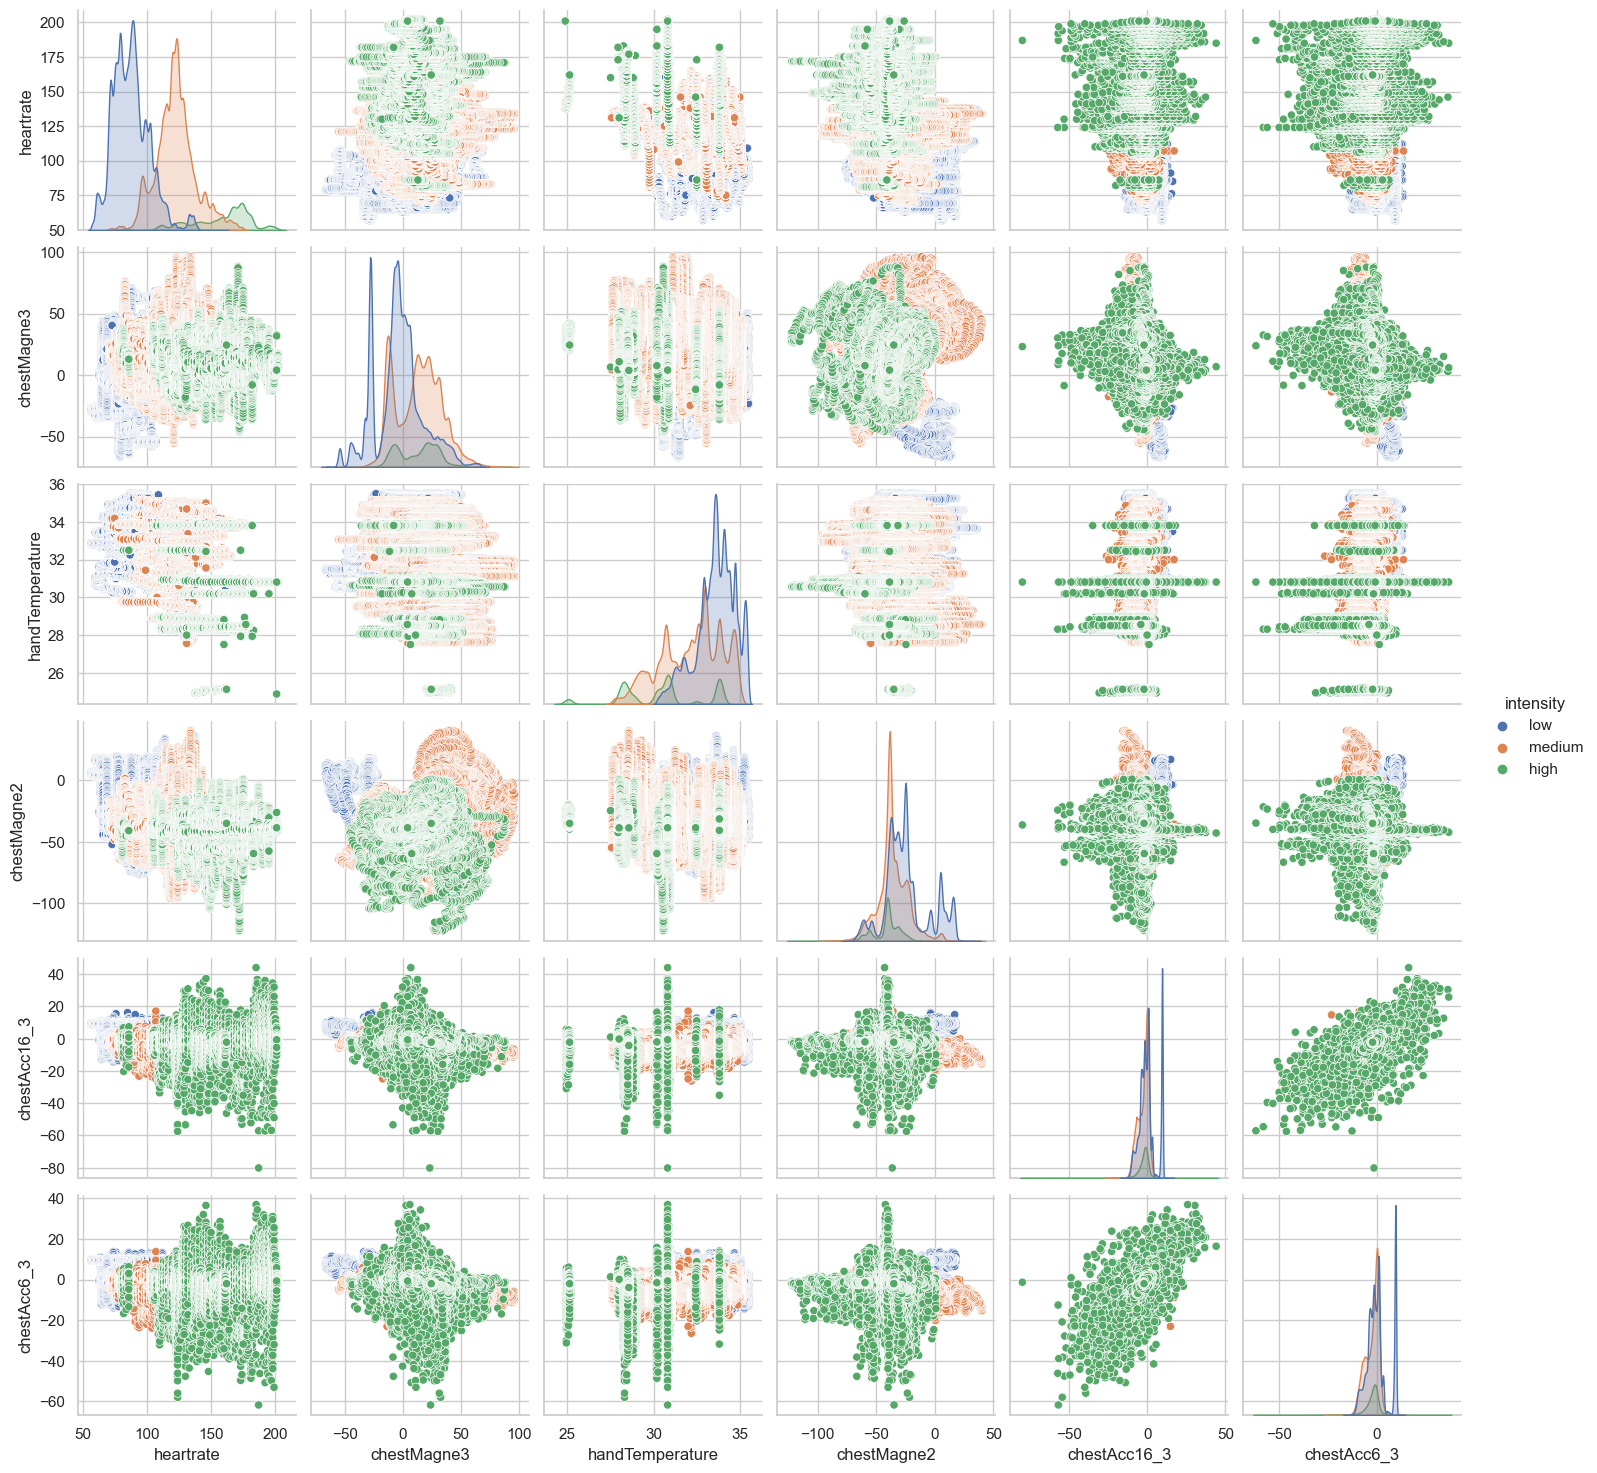

In [221]:
 sns.pairplot(df_full, vars = ['heartrate','chestMagne3','handTemperature','chestMagne2','chestAcc16_3',
                               'chestAcc6_3'], hue='intensity')
plt.show()

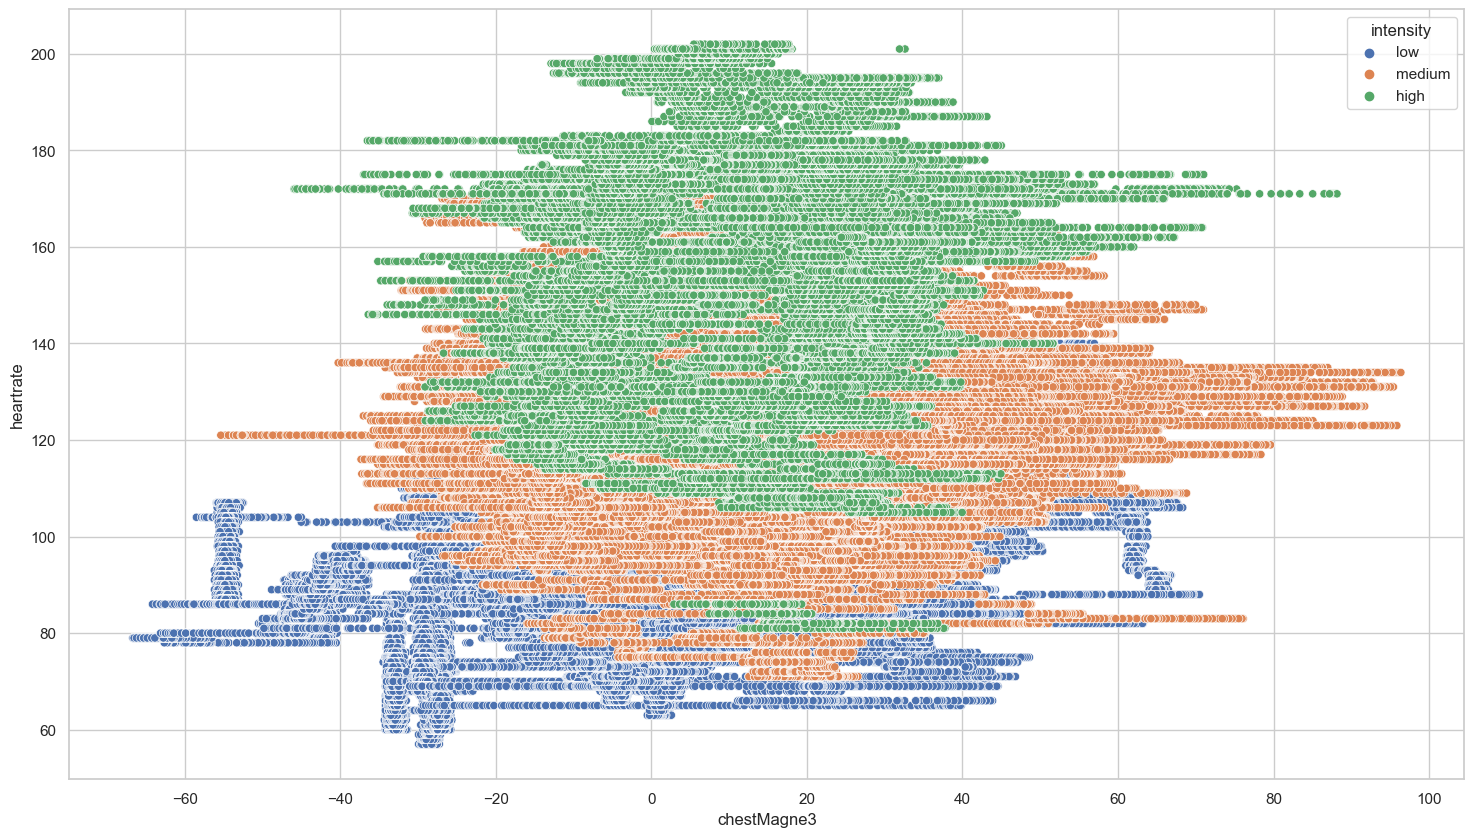

In [222]:
fig,axs = plt.subplots(ncols=1, figsize=(18,10))
sns.scatterplot( x = "chestMagne3", y = "heartrate", data = df_full,ci=None,color='red',hue='intensity')

plt.show()

# Hypotesis <a class="anchor" id="fifth-bullet"></a>

Based on the observations of the exploratory analysis, we can develop the following hypothesis.


#### Alternative Hypothesis

If heart rate depends on the intensity of the activity, then high intensity activities have a higher average heart rate than low and medium intensity activities.


#### Null Hypothesis

High intesity have the same heart rate than others intenties (low and medium).

To test our hypothesis, first, we generated a table of average heart rate grouped by intensity, another table of the standard deviation of heart rate grouped by intensity and another table with a heart rate count grouped by intensity.

In [43]:
#We split our data randomly for hypothesis testing.
X_train, X_test = train_test_split(df_full,  test_size=0.5, random_state=42)

In [44]:
intensity_means=X_train[X_train['intensity']!='-'].groupby('intensity')['heartrate'].mean()
intensity_std=X_train[X_train['intensity']!='-'].groupby('intensity')['heartrate'].std()
intensity_count=X_train[X_train['intensity']!='-'].groupby('intensity')['heartrate'].count()

In [45]:
intensity_means

intensity
high      158.373212
low        87.537464
medium    122.419666
Name: heartrate, dtype: float64

In [46]:
intensity_std

intensity
high      22.553626
low       13.977540
medium    15.648677
Name: heartrate, dtype: float64

In [47]:
intensity_count

intensity
high       71785
low       489017
medium    399913
Name: heartrate, dtype: int64

In addition, we calculated the average, standard deviation and heart rate count considering all data without grouping by intensity:

In [48]:
general_mean=intensity_means.mean()
general_std=intensity_std.mean()
general_count=intensity_count.mean()

In [49]:
print(general_mean)
print(general_std)
print(general_count)

122.77678062797001
17.39328113520484
320238.3333333333


With these data, we can perform a z-test, calculating the combined error between the High intensity data and the overall average.

In [50]:
combinederror=(((intensity_std['high']*2)/intensity_count['high'])+((general_std)/general_count))*0.5   
z=(intensity_means['high']-general_mean)/combinederror

In [51]:
p_value_from_normal_for_diff = (1-stats.norm.cdf(z))
print ('one_tail High intensity - general average', p_value_from_normal_for_diff)

one_tail High intensity - general average 0.0


The z-test above is performed to obtain the probability value (p-value) with a 95% confidence interval.

The p-value is 0 in the z-test above. Therefore, there is strong evidence to reject the null hypothesis and we conclude that the heart rate of high activities will be higher than the average heart rate considering all activities.

# Model to predict Heart Rate <a class="anchor" id="six-bullet"></a>

## Linear regresion model

For our first model we will use the multiple linear regression method.
Multiple linear regression is an extension of simple linear regression used to predict an outcome variable (y) on the basis of multiple distinct predictor variables (x).

In [114]:
# linear regression
#we define our independent variables X and our dependent variable y
X = df_full[['chestMagne3','handTemperature','chestMagne2','chestAcc16_3','chestAcc6_3','ankleAcc6_1']]
y = df_full['heartrate']

In [115]:
#we split the data into test and training (30/60)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [116]:
#inisialize the model
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

In [117]:
print()
print("*** Linear Regression Coefficients  ***")
print(linreg.intercept_)
print(linreg.coef_)
print()
RMSE_linreg = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print('Linear Regression (RMSE): ', RMSE_linreg)

print('Coefficient de correlacion PEARSON (LINREG):', linreg.score(X,y))


*** Linear Regression Coefficients  ***
253.45682247726597
[ 0.35032137 -5.04502916 -0.46727035  0.23070979 -0.45362608  0.33076965]

Linear Regression (RMSE):  20.530447258107586
Coefficient de correlacion PEARSON (LINREG): 0.42008514169253697


### Actual vs. predicted values

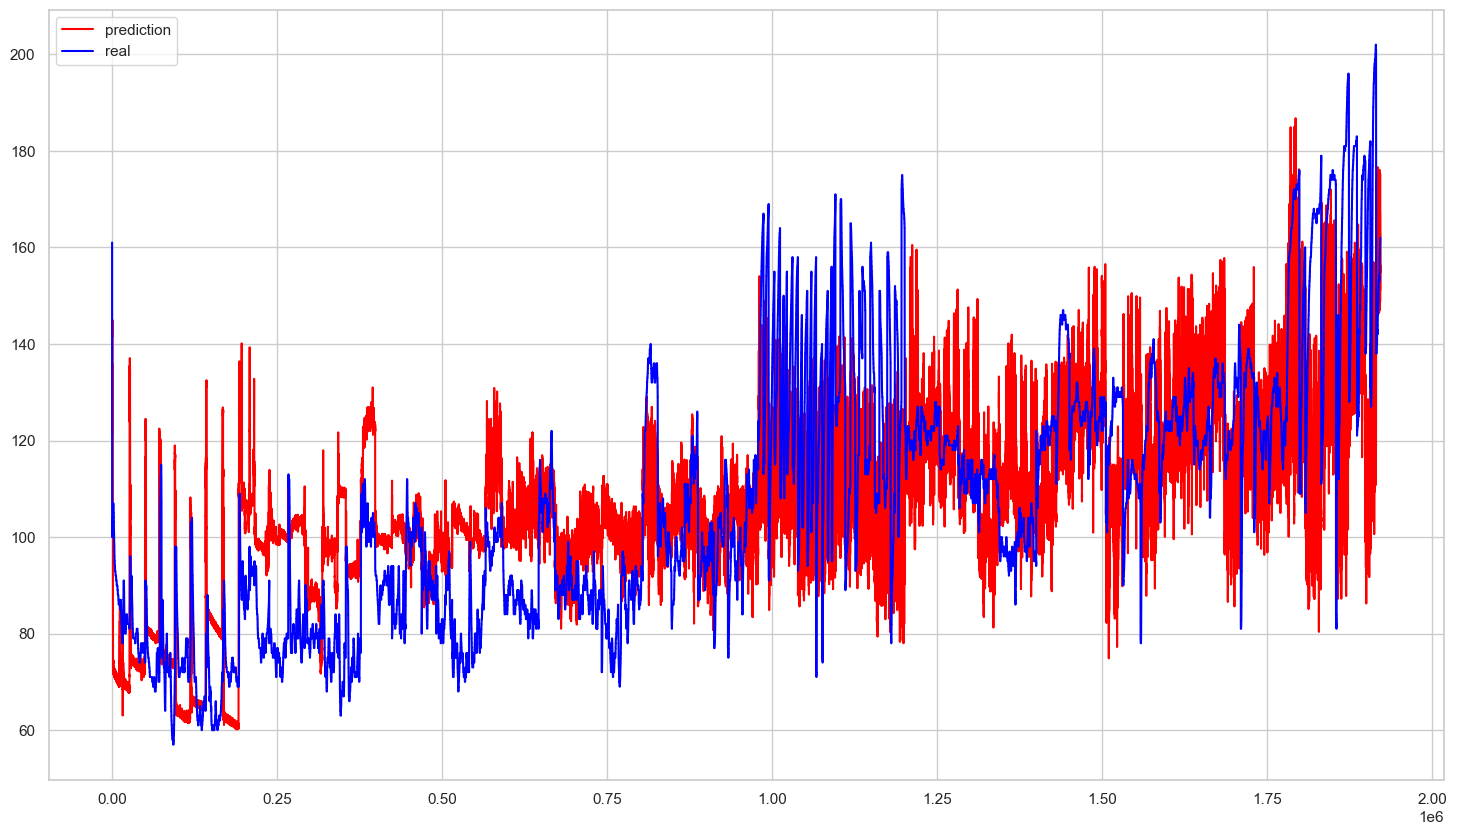

In [258]:
# Regresion Lineal
#y = df_full['heartrate']
yfit = linreg.predict(X)
#print(len(yfit))
#print(len(y))
#print(yfit[:30])
f, ax = plt.subplots(figsize=(18, 10))
plt.plot(range(len(y)),yfit,label='prediction',color='red')
#plt.plot(y_test[:10000])
plt.plot(range(len(y)),y,label='real',color='blue')
plt.legend()

## K-Folds cross-validator

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

 
The following is an example of how kfold works with a 5-data dataset:


In [261]:
kf=KFold(n_splits=5, random_state=None, shuffle=False)

##Ejemplo de como funciona kfold con un dataset de 5 datos
for train_index, test_index in kf.split([1,2,3,4,K-Folds cross-validator5]):
  print(train_index, test_index)

[1 2 3 4] [0]
[0 2 3 4] [1]
[0 1 3 4] [2]
[0 1 2 4] [3]
[0 1 2 3] [4]


Now, we will apply a cross-validation to the linear regression above.
First, We define the metrics to be measured in the model.

In [262]:
#We define the metrics to be measured in the mode.

def get_score(model, X_train, X_test, y_train, y_test):
  model.fit(X_train,y_train)
  y_fit=model.predict(X_test)
  return metrics.r2_score(y_test,y_fit)
  
def get_varscore(model, X_train, X_test, y_train, y_test):
  model.fit(X_train,y_train)
  y_fit=model.predict(X_test)
  return metrics.explained_variance_score(y_test, y_fit)

Here we train each model with the different splits of the kfold (5 folds).

In [263]:
RMSE = []
Pearson = []
kf = KFold(n_splits=5,shuffle=True)
linreg = LinearRegression()

for k,(train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    linreg.fit(X_train, y_train)
    RMSE.append(np.sqrt(metrics.mean_squared_error(y_test, linreg.predict(X_test))))
    Pearson.append(linreg.score(X,y))
print(RMSE)
print('RMSE: %.3f (%.3f)' % (mean(RMSE), std(RMSE)))
print(Pearson)
print('Pearson Coefficient: %.3f (%.3f)' % (mean(Pearson), std(Pearson)))

#print('Coefficient de correlacion PEARSON (LINREG):', linreg.score(X,y))
#RMSE_linreg = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
#print('Linear Regression (RMSE): ', RMSE_linreg)

[20.489365658996807, 20.52080140118446, 20.60301532672921, 20.518355085691816, 20.556419037899296]
RMSE: 20.538 (0.039)
[0.4200845988129017, 0.4200844344789745, 0.42008380773548415, 0.4200851230113738, 0.42008451727656926]
Pearson Coefficient: 0.420 (0.000)


We observe that the RMSE value does not vary too much, it remains between 20.48 and 20.60 and the Pearson coefficient remains practically fixed at 0.42.
 This indicates that our model is stable and the results do not depend on the selection of the training and test sample.

## Random forest regression (decision trees) model

Random Forest is an example of an ensemble method built on decision trees for classification, however, it can also work in the case of regression (i.e. continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor''.

In [66]:
#we use the get_dummies method of pandas to convert categorical variables into dummy/indicator variables. 

features = pd.get_dummies(df_full)

In [67]:
features

timestamp  activityID  heartrate  handTemperature  handAcc16_1  \
923437       37.66           1      161.0           30.375      2.21530   
923438       37.67           1      161.0           30.375      2.29196   
923439       37.68           1      161.0           30.375      2.29090   
923440       37.69           1      161.0           30.375      2.21800   
923441       37.70           1      100.0           30.375      2.30106   
...            ...         ...        ...              ...          ...   
2844863      95.06          24      162.0           25.125      4.99466   
2844864      95.07          24      162.0           25.125      5.02764   
2844865      95.08          24      162.0           25.125      5.06409   
2844866      95.09          24      162.0           25.125      5.13914   
2844867      95.10          24      162.0           25.125      5.00812   

         handAcc16_2  handAcc16_3  handAcc6_1  handAcc6_2  handAcc6_3  ...  \
923437       8.27915      5.58753     2.24689     8.55387     5.77143  ...   
923438       7.67288      5.74467     2.27373     8.14592     5.78739  ...   
923439       7.14240      5.82342     2.26966     7.66268     5.78846  ...   
923440       7.14365      5.89930     2.22177     7.25535     5.88000  ...   
923441       7.25857      6.09259     2.20720     7.24042     5.95555  ...   
...              ...          ...         ...         ...         ...  ...   
2844863      6.01881      5.59830     4.90787     6.05780     5.68357  ...   
2844864      5.90369      5.48372     4.89090     5.95209     5.56301  ...   
2844865      5.71370      5.48491     4.97981     5.87584     5.45738  ...   
2844866      5.63724      5.48629     4.97690     5.69448     5.29167  ...   
2844867      5.40645      5.02326     4.97362     5.45272     5.14120  ...   

         activity_lying  activity_rope jumping  activity_running  \
923437                1                      0                 0   
923438                1                      0                 0   
923439                1                      0                 0   
923440                1                      0                 0   
923441                1                      0                 0   
...                 ...                    ...               ...   
2844863               0                      1                 0   
2844864               0                      1                 0   
2844865               0                      1                 0   
2844866               0                      1                 0   
2844867               0                      1                 0   

         activity_sitting  activity_standing  activity_vacuum cleaning  \
923437                  0                  0                         0   
923438                  0                  0                         0   
923439                  0                  0                         0   
923440                  0                  0                         0   
923441                  0                  0                         0   
...                   ...                ...                       ...   
2844863                 0                  0                         0   
2844864                 0                  0                         0   
2844865                 0                  0                         0   
2844866                 0                  0                         0   
2844867                 0                  0                         0   

         activity_walking  intensity_high  intensity_low  intensity_medium  
923437                  0               0              1                 0  
923438                  0               0              1                 0  
923439                  0               0              1                 0  
923440                  0               0              1                 0  
923441                  0               0              1                 0  
...

In [68]:
# Variable we want to predict. 
labels = np.array(features['heartrate'])
#Delete the variable to be predicted from the original dataset (axis 1 indicates that it is a column).
features= features.drop('heartrate', axis = 1)
#Save the independent variables as a list. 
feature_list = list(features.columns)
#Convert the characteristics to NP array
features = np.array(features)

In [69]:
# Generate a training and validation set. 
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                         random_state = 42)

In [70]:
print('Dimensions of the training set data:', train_features.shape)
print('Dimensions of the training set data labels:', train_labels.shape)
print('Test set data dimensions:', test_features.shape)
print('Dimensions of the test set data labels:', test_labels.shape)

Dimensions of the training set data: (1441073, 77)
Dimensions of the training set data labels: (1441073,)
Test set data dimensions: (480358, 77)
Dimensions of the test set data labels: (480358,)


We will perform a first test of our model, using the following parameters: n_estimators=10, max_depth = 3

In [75]:
#Generate an instance of the RandomForestRegressor model
rf =RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)
#Training the model with the test set
rf.fit(train_features, train_labels);

In [112]:
#Making predictions with test data
predictions = rf.predict(test_features)
#Calculate the differences in absolute terms
errors = abs(predictions - test_labels)
# Deliver Mean Absolute Error (mae)
print('Mean Absolute Error (mae):', round(np.mean(errors), 2), 'degrees')

Mean Absolute Error (mae): 9.36 degrees


In [77]:
# Determine the performance of the model.
mape = 100 * (errors / test_labels)

# Calculate the precision
accuracy = 100 - np.mean(mape)
print('Precision (Accuracy):', round(accuracy, 2), '%.')

Precision (Accuracy): 91.25 %.


### Actual vs. predicted values model Random Forest 1

In [263]:
timestamp_real = features[:, feature_list.index('timestamp')]
dates = [timestamp for timestamp in zip(timestamp_real)]
true_data = pd.DataFrame(data = {'time': timestamp_real, 'real': labels})
timestamp_test = test_features[:, feature_list.index('timestamp')]

#Dataframe with the predicted data and their times.
predictions_data = pd.DataFrame(data = {'time': timestamp_test, 'prediction': predictions})

<AxesSubplot:xlabel='timestamp', ylabel='heartrate'>

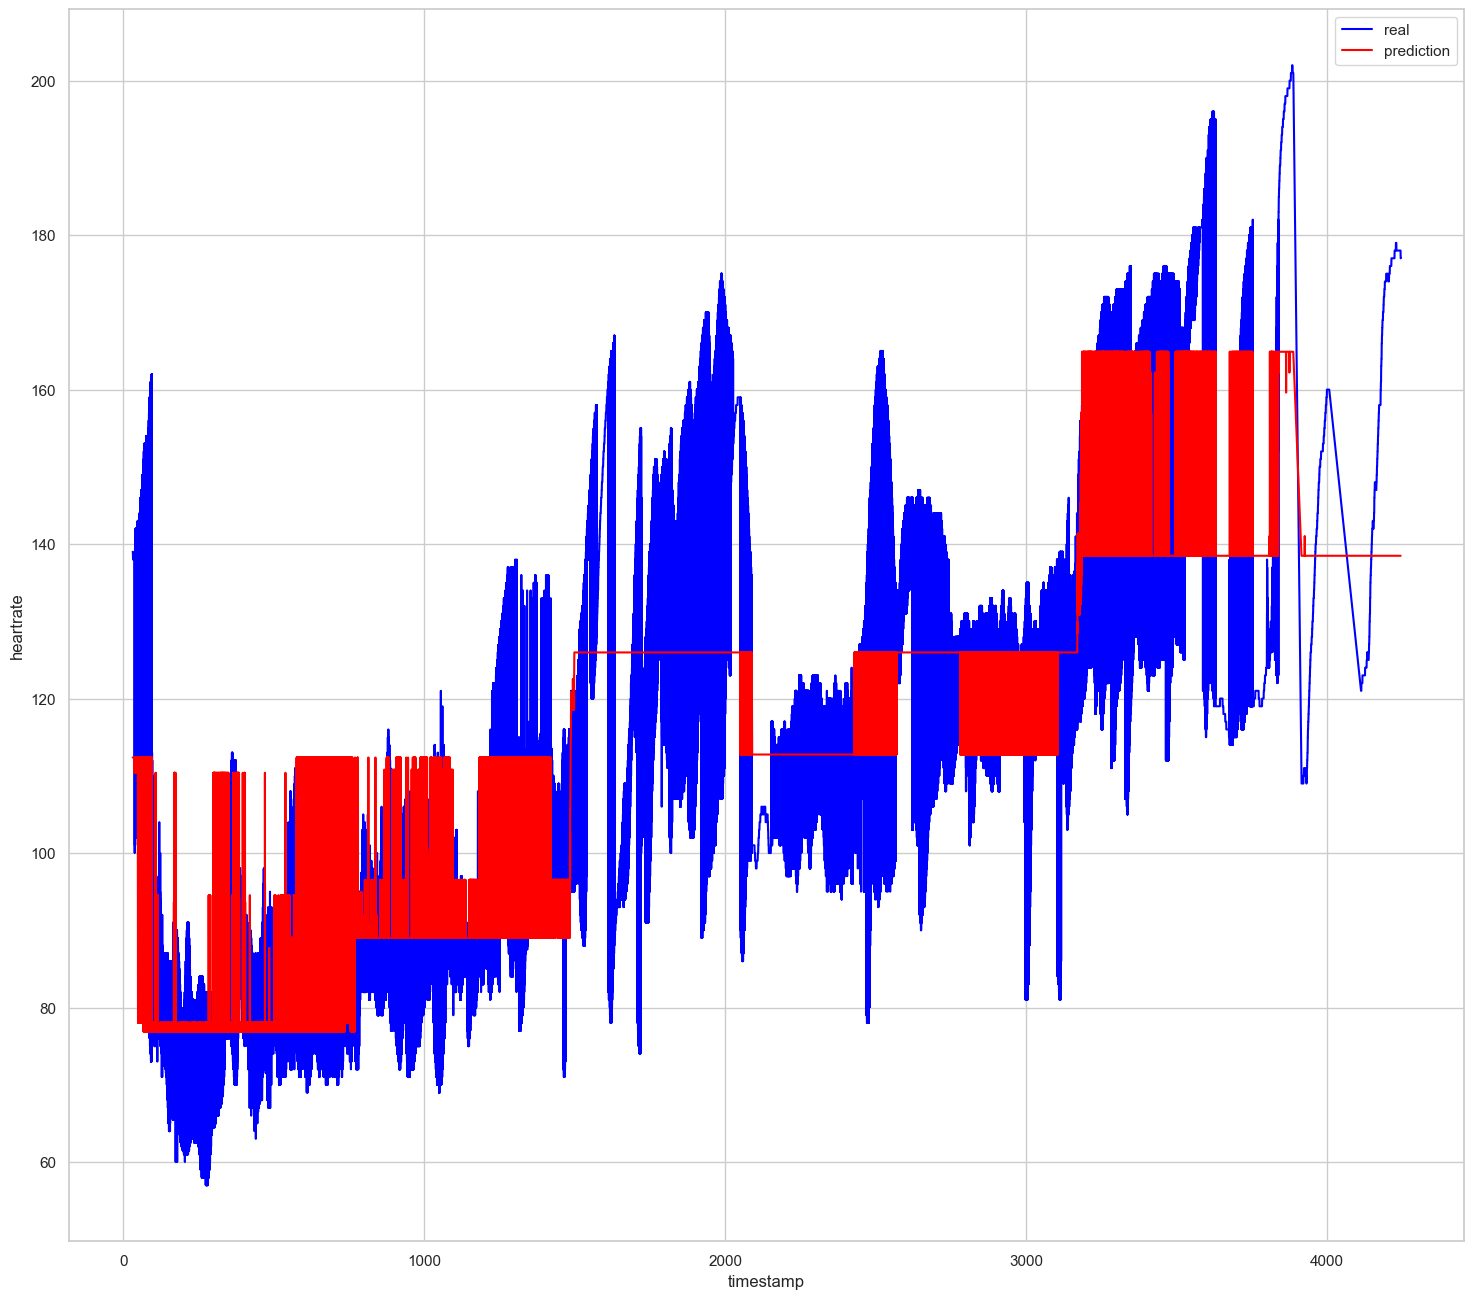

In [264]:
#Plot actual values
f, ax = plt.subplots(figsize=(18, 16))
sns.lineplot( x = "timestamp", y = "heartrate", data = df_full,ci=None,label='real',color='blue')

#plot predicted values
sns.lineplot( x = "time", y = "prediction", data = predictions_data,ci=None,label='prediction',color='red')

Next, we will perform a second test of our model, using the following parameters: n_estimators=100, max_depth = None

In [270]:
#Generate an instance of the RandomForestRegressor model
rf =RandomForestRegressor(n_estimators=100, max_depth = None, random_state=42)
#Training the model with the test set
rf.fit(train_features, train_labels);

In [271]:
#Making predictions with test data
predictions = rf.predict(test_features)
#Calculate the differences in absolute terms
errors = abs(predictions - test_labels)
# Calculate the Mean Absolute Error (mae)
print('Error Absoluto Medio (mae):', round(np.mean(errors), 2), 'degrees')

Error Absoluto Medio (mae): 0.29 grados


In [272]:
# Determine the performance of the model.
mape = 100 * (errors / test_labels)
# Calculate the accuracy
accuracy = 100 - np.mean(mape)
print('Precision (Accuracy):', round(accuracy, 2), '%.')

Precision (Accuracy): 99.72 %.


### Actual vs. predicted values model Random Forest 2

In [273]:
timestamp_real = features[:, feature_list.index('timestamp')]
dates = [timestamp for timestamp in zip(timestamp_real)]
true_data = pd.DataFrame(data = {'time': timestamp_real, 'real': labels})
timestamp_test = test_features[:, feature_list.index('timestamp')]

#Dataframe with the predicted data and their times.
predictions_data = pd.DataFrame(data = {'time': timestamp_test, 'prediction': predictions})

<AxesSubplot:xlabel='timestamp', ylabel='heartrate'>

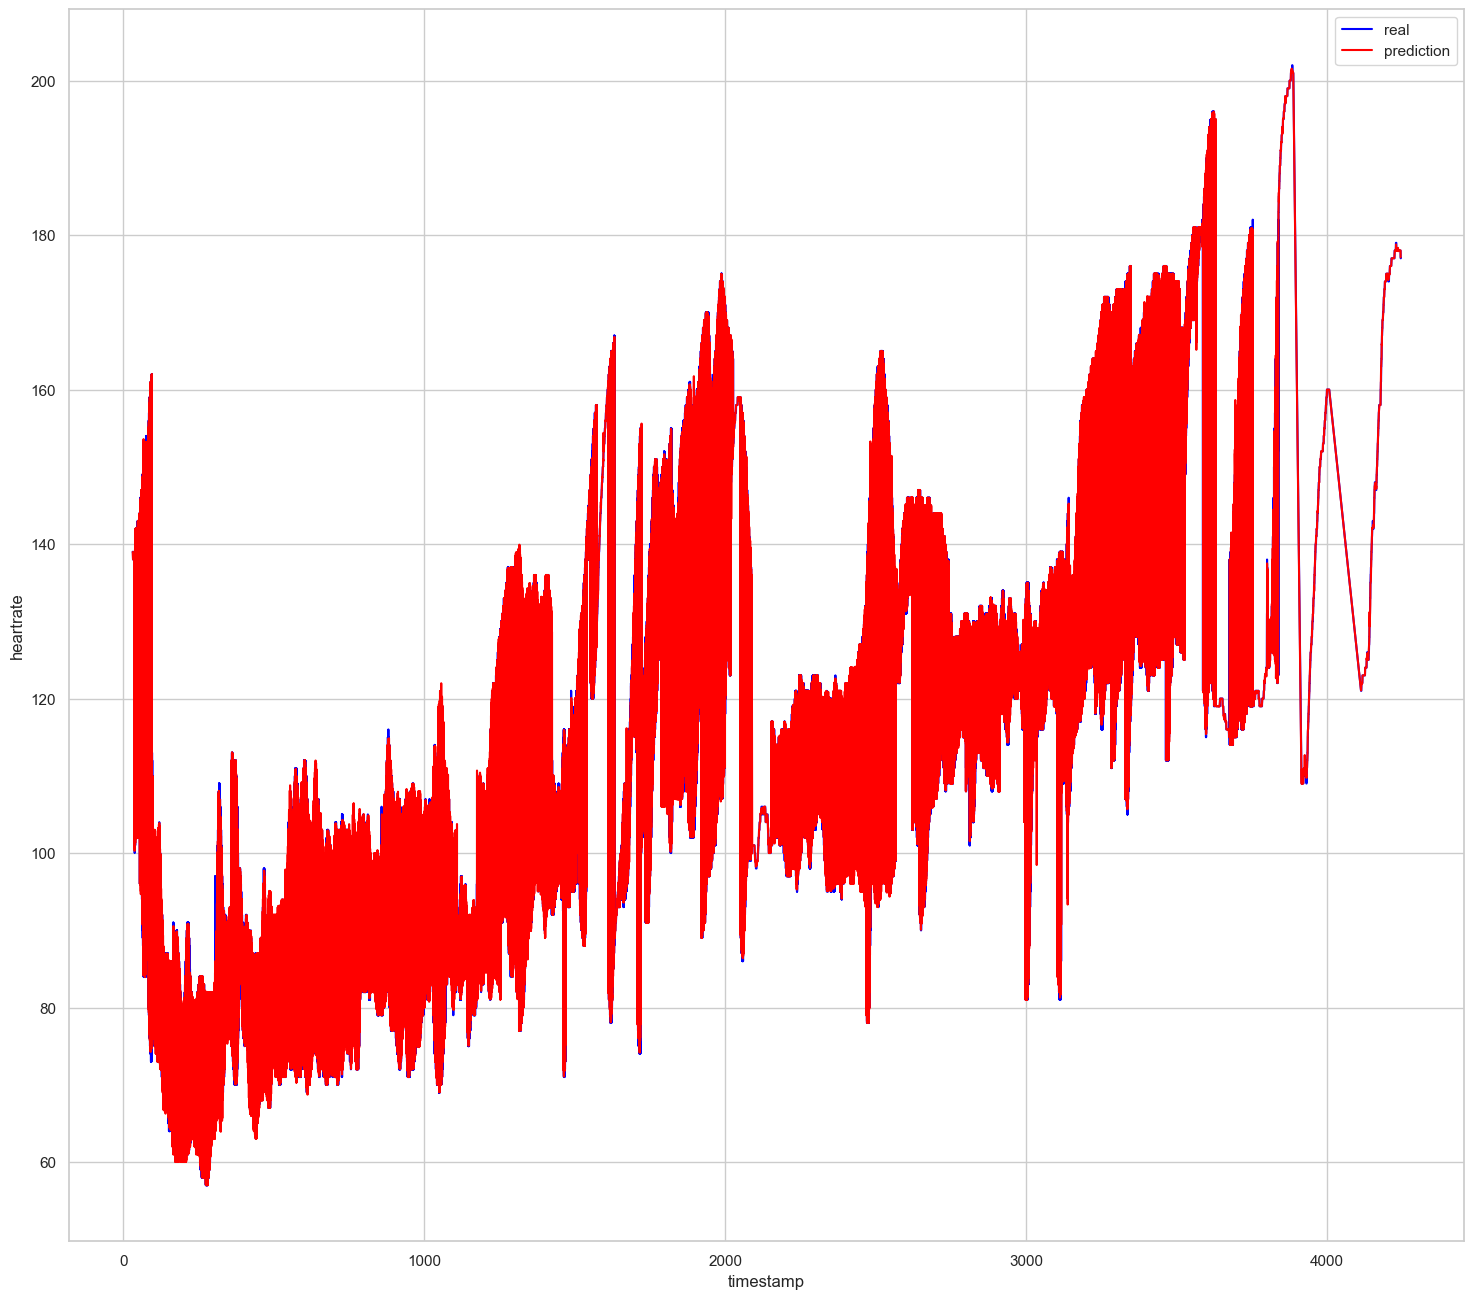

In [274]:
#Plot actual values
f, ax = plt.subplots(figsize=(18, 16))
sns.lineplot( x = "timestamp", y = "heartrate", data = df_full,ci=None,label='real',color='blue')

#plot predicted values
sns.lineplot( x = "time", y = "prediction", data = predictions_data,ci=None,label='prediction',color='red')

# Model to classify activities <a class="anchor" id="seven-bullet"></a>

We defined our independent variables using the same variables that correlate with heart rate, since, as we saw in the exploratory analysis, heart rate can also be explained by the type of activity performed.

## K-means clustering with PCA-reduced data

In [98]:
## Train dataset
pca_model = df_full.drop(["timestamp", "Subject_ID","activityID"],1)[['activity','intensity','heartrate','chestMagne3','handTemperature','chestMagne2','chestAcc16_3','chestAcc6_3','ankleAcc6_1','ankleAcc6_2','ankleAcc6_3']]


X_train = pca_model.drop(['activity','intensity'], axis=1)
y_train = pca_model['intensity'].values

# Test Dataset
X_test = pca_model.drop(['activity','intensity'], axis=1)
y_test = pca_model['intensity'].values

Here we use the elbow method to determine the number of characteristics that best explain the data.

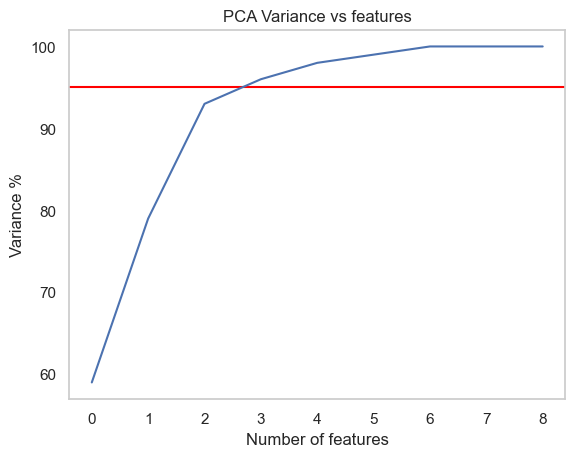

In [100]:
## PCA on provided dataset
from sklearn.decomposition import PCA

pca_pamap2 = PCA()
pca_pamap2.fit(X_train)

feature_var=np.cumsum(np.round(pca_pamap2.explained_variance_ratio_,2)*100)

plt.title("PCA Variance vs features")
plt.ylabel("Variance %")
plt.xlabel("Number of features")
l = plt.axhline(95, color="red")

plt.plot(feature_var)
plt.grid()

And we conclude that the number of components must be 2, so we use this value as the parameter of our model.

In [101]:
## variance expalied for each principal component
My_pca = PCA(n_components=2)
X_train=My_pca.fit_transform(X_train)
print('Explained variation per principal component: {}'.format(My_pca.explained_variance_ratio_))

Explained variation per principal component: [0.59426943 0.19673564]


In [102]:
pc_dataframe=pd.DataFrame(X_train)
activity_df=pd.DataFrame(y_train)

The components are as follows:

In [103]:
pc_dataframe

0          1
0        68.533834   4.476809
1        68.106829   3.946883
2        68.427010   4.293459
3        68.061184   4.175476
4        19.061154  27.825219
...            ...        ...
1921426  55.387704  -6.464325
1921427  55.003887  -6.787170
1921428  55.099001  -6.515319
1921429  55.010092  -6.992647
1921430  55.031751  -6.846957

[1921431 rows x 2 columns]

We add the intensity level to compare the final model clusters with the real values.

In [104]:
df_full1=pd.merge(pc_dataframe,activity_df, left_index=True, right_index=True)

In [105]:
df_full1

0_x          1   0_y
0        68.533834   4.476809   low
1        68.106829   3.946883   low
2        68.427010   4.293459   low
3        68.061184   4.175476   low
4        19.061154  27.825219   low
...            ...        ...   ...
1921426  55.387704  -6.464325  high
1921427  55.003887  -6.787170  high
1921428  55.099001  -6.515319  high
1921429  55.010092  -6.992647  high
1921430  55.031751  -6.846957  high

[1921431 rows x 3 columns]

The actual values are as follows:

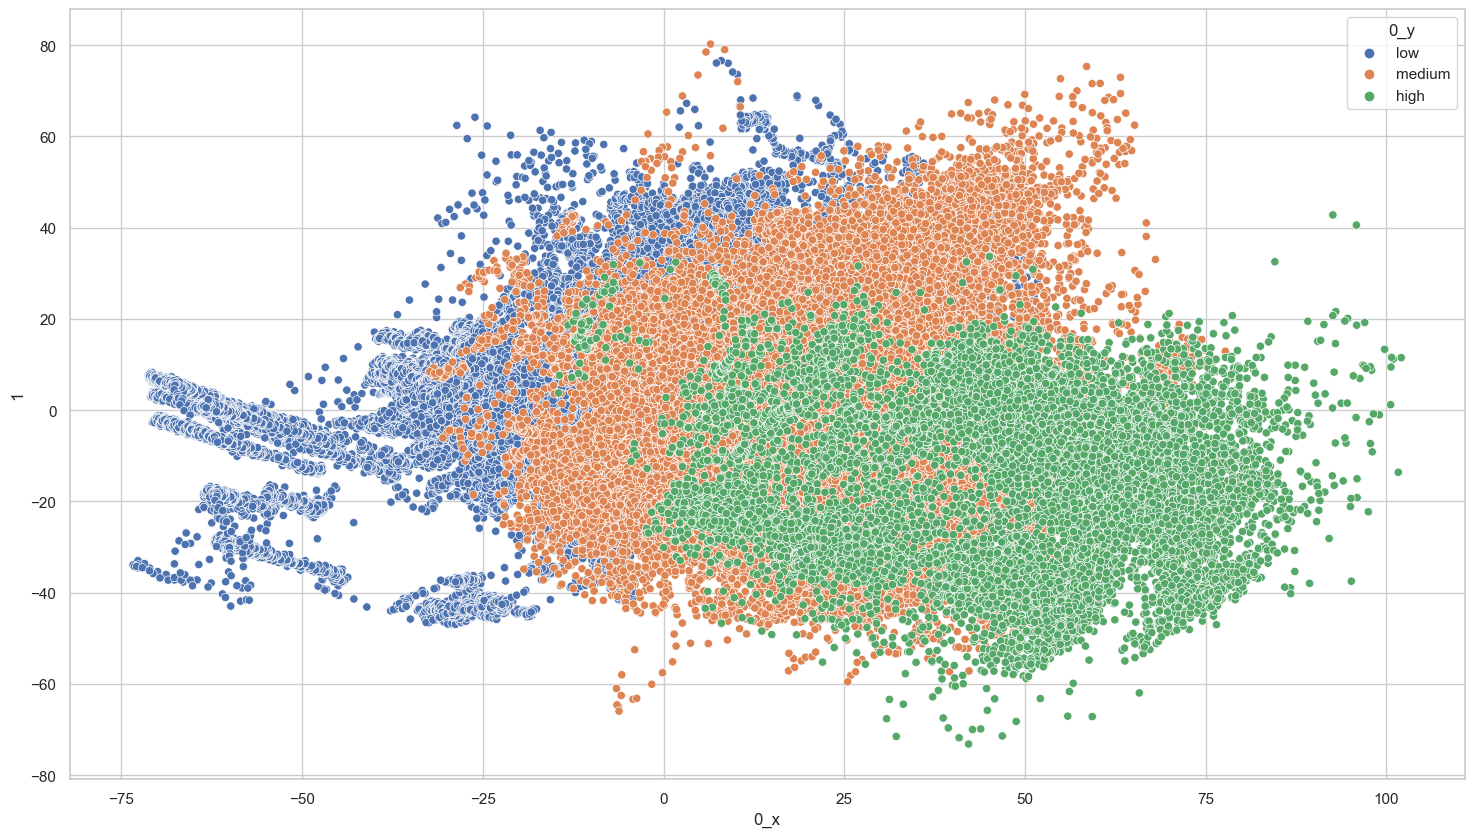

In [130]:


fig,axs = plt.subplots(ncols=1, figsize=(18,10))
sns.scatterplot( x = '0_x', y = 1, data = df_full1,ci=None,color='red',hue='0_y')

plt.show()

In [106]:
kmeans = KMeans(n_clusters=3 ,random_state=10)
kmeans.fit(df_full1[['0_x',1]])
clusters = kmeans.predict(df_full1[['0_x',1]])
centers_pulsars = kmeans.cluster_centers_

The values grouped by the kmeans algorithm are as follows:

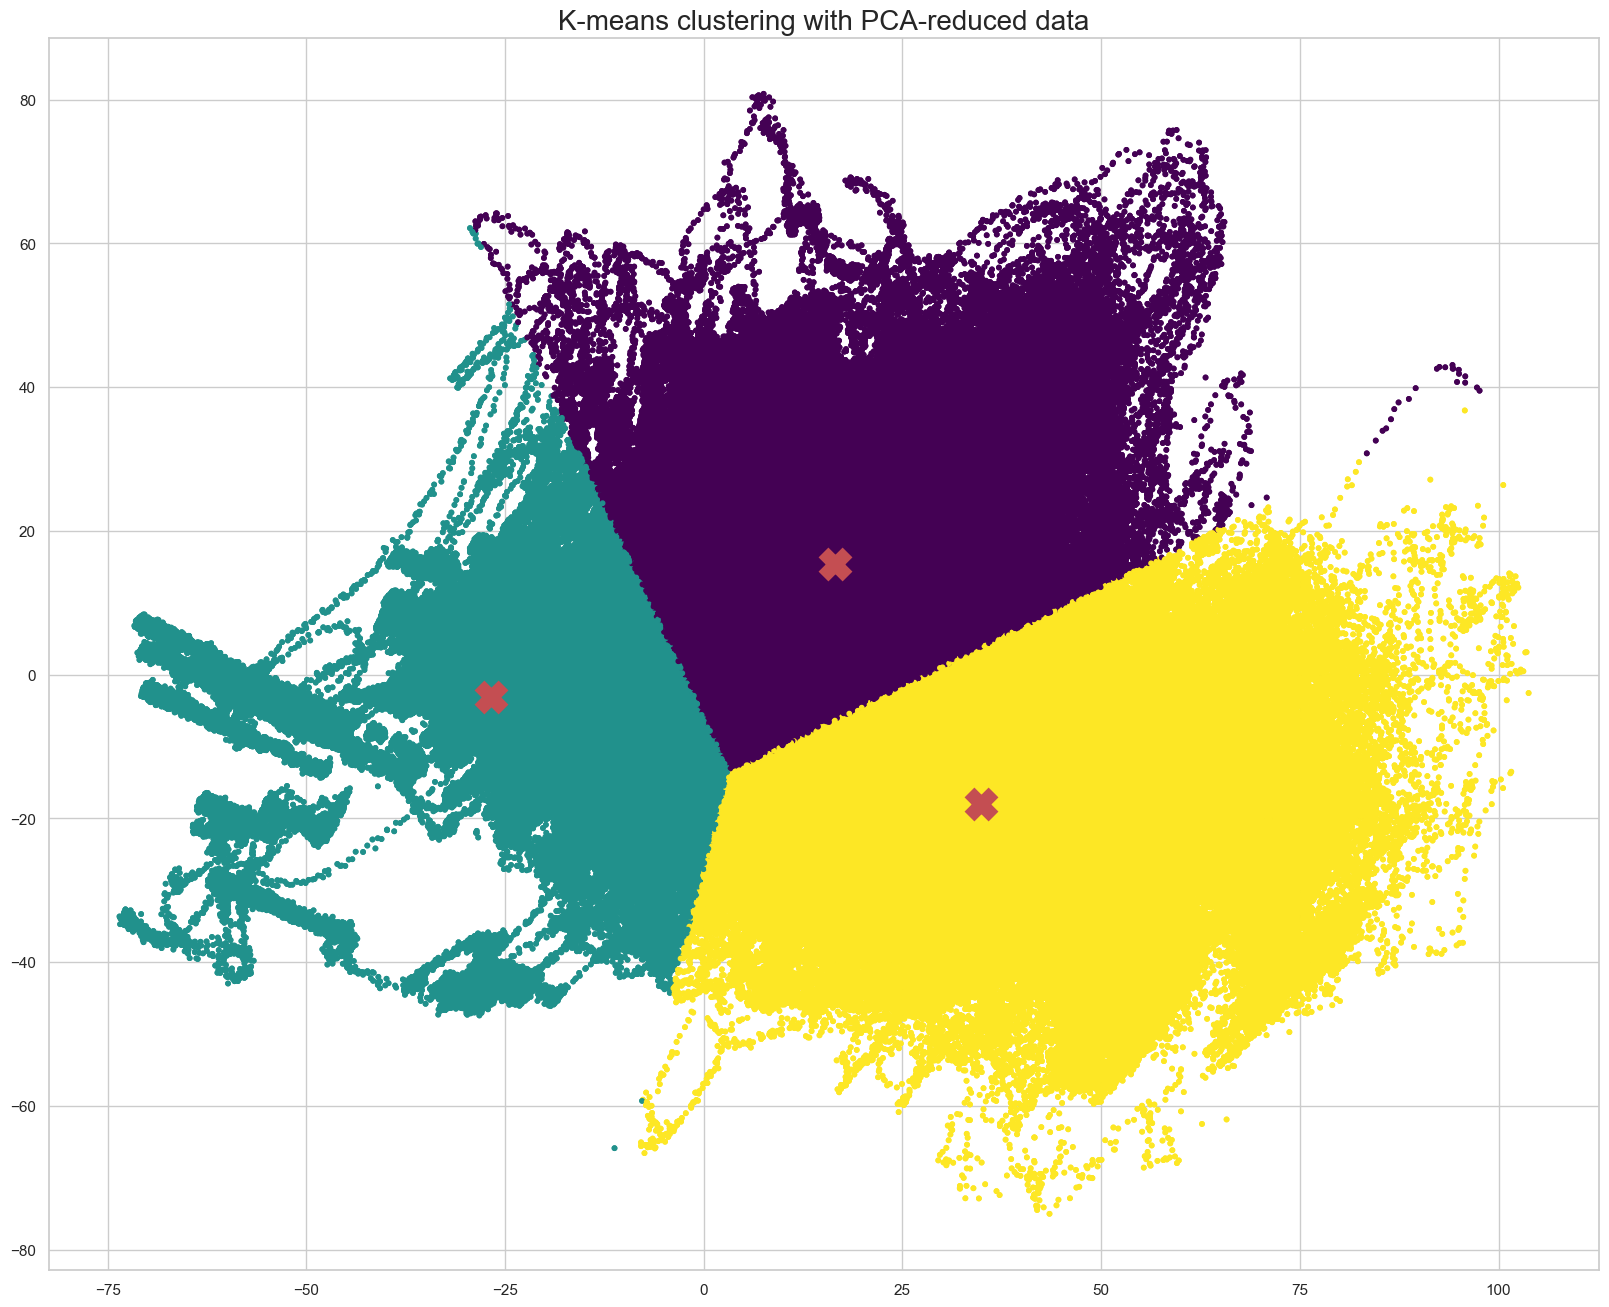

In [107]:
def plot_clusters(X, clusters=None, centers=None):
    plt.scatter(X[:, 0], X[:, 1], c=clusters, s=10, cmap="viridis")
    
    if np.any(centers):
        plt.scatter(
            centers[:, 0], centers[:, 1], marker="x", s=300, linewidths=10, color="r"
        )
X_plot = np.array(df_full1[['0_x',1]])
plt.figure(figsize=[20, 16])
plot_clusters(X_plot, clusters=clusters, centers=centers_pulsars)
plt.title("K-means clustering with PCA-reduced data", fontsize=20)
plot_clusters(X_plot, clusters=clusters, centers=centers_pulsars)

In [108]:
#KMEANS WITH PCA and ALL VARIABLES
kmeans.fit(df_full1[['0_x',1]])
clusters_con_pca=pd.DataFrame(kmeans.labels_, columns=['Class_kmeans_con_pca'])

finalDf = pd.concat([df_full1[['0_x',1]],activity_df], axis = 1)
finalDf = pd.concat([finalDf,clusters_con_pca], axis = 1)

print('Kmeans metrics with PCA and all features')
# Calculate homogeneity and completeness.
homogeneity = metrics.homogeneity_score(finalDf[0], finalDf['Class_kmeans_con_pca'])
completeness = metrics.completeness_score(finalDf[0], finalDf['Class_kmeans_con_pca'])
v_measure=v_measure_score(finalDf[0], finalDf['Class_kmeans_con_pca'])
print('homogeneity',float(homogeneity))
print('completeness',float(completeness))
print('v_measure',float(v_measure))

Kmeans metrics with PCA and all features
homogeneity 0.3652412089228438
completeness 0.3149987398958757
v_measure 0.33826452200737317


We found clear differences between the actual values and the values that the algorithm clustered, which confirms that the k-means algorithm is not appropriate to perform classification of categorical values and should be discarded, this happens because k-means only works when the mean is defined, categorical data cannot calculate the mean value.

## K-Nearest Neighbors

The K-Nearest Neighbors (KNN) algorithm tries to find the 𝐾 points closest to a given point in order to infer its value. This algorithm can be used for both classification and regression problems.

Although simple, it is used in the resolution of a multitude of problems, such as in recommendation systems, semantic search and anomaly detection.

Its pros are that it is easy to learn and implement. Its disadvantages are that it uses the entire dataset to train "each point" and therefore requires the use of a lot of memory and processing resources (CPU). For these reasons kNN tends to work better on small datasets and without a huge amount of features.

We create a function that will allow us to evaluate our models based on the confusion matrix.

In [81]:
activityIDdict = {0: 'transient', 1:'lying', 2:'sitting', 3:'standing',
              4:'walking', 5:'running', 6:'cycling', 7:'Nordic walking',
              9:'watching TV', 10:'computer work', 11:'car driving',
              12:'ascending stairs', 13:'descending stairs', 16:'vacuum cleaning',
              17:'ironing', 18:'folding laundry', 19:'house cleaning',
              20:'playing soccer', 24:'rope jumping'}

protocol_acts = [1,2,3,4,5,6,7,17,16,24,12,13]

In [91]:
def plot_confusion_matrix(model,X_test,y_test,title='',is_ml=False, labels={}):
    
  ticks = list(map(lambda x : activityIDdict[x], np.unique(y_test).tolist())) if labels=={} else labels.values()
  preds = model.predict(X_test)
  pred_cat = preds if is_ml else np.argmax(preds,axis=1)
  print('model accuracy on test set is: {0:.2f}%'.format(accuracy_score(y_test,pred_cat)*100))
  plt.figure(figsize=(15,8),dpi=120)
  sns.heatmap(confusion_matrix(y_test,pred_cat),cmap='Blues',annot=True, fmt='d',xticklabels=ticks,yticklabels=ticks)
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title(title)
  plt.show()

In [92]:
X = df_full[['chestMagne3','handTemperature','chestMagne2','chestAcc16_3','chestAcc6_3','ankleAcc6_1']].values
y = df_full['activityID'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#Formula to normalize the data. It leaves them between 0 and 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Seeking the best value for k

Next, we will look for the best value of k to use in our KNN model. For this, we will plot the accuracy for k between 1 and 10.

In [93]:
k_range = range(1, 10)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))


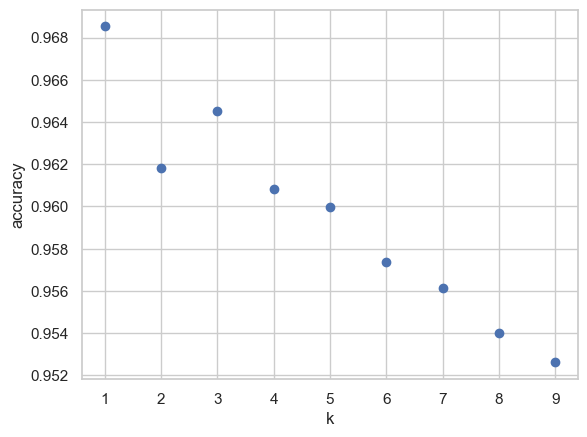

In [94]:
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)

We clearly observe that the best accuracy value is obtained at k=2, and it decreases as k increases. Therefore, in our KNN model we will use k=2.

In [95]:
n_neighbors = 2

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.98
Accuracy of K-NN classifier on test set: 0.96


### Confusion matrix and accuracy

model accuracy on test set is: 96.18%


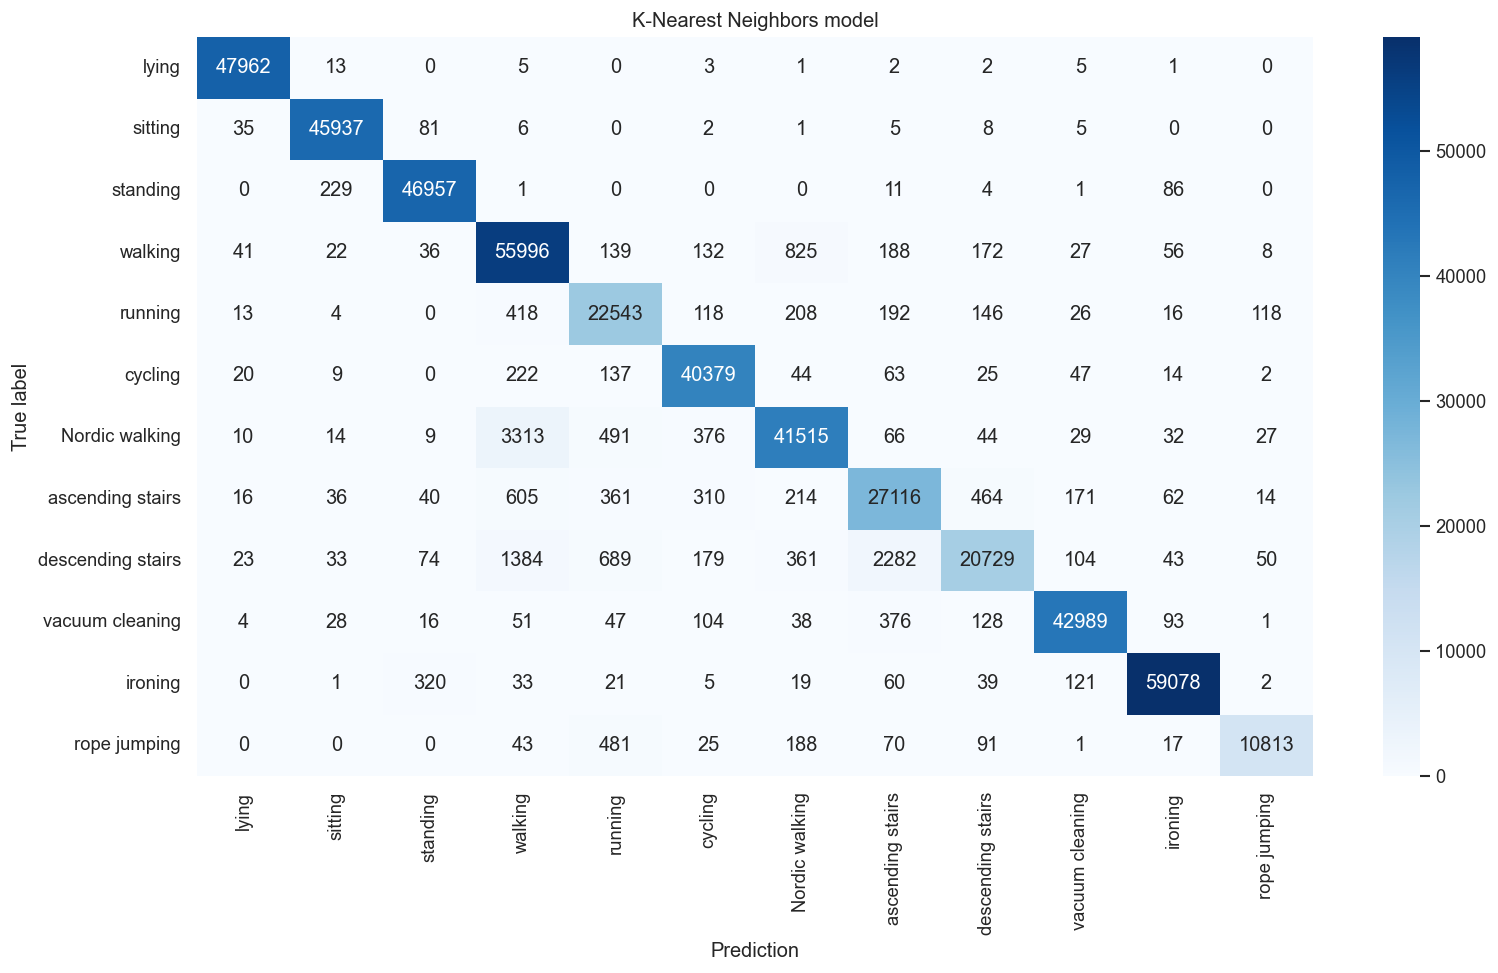

In [96]:
plot_confusion_matrix(knn,X_test,y_test,"K-Nearest Neighbors model",is_ml=True)### Confusion matrix and accuracy

## Classification model with decision trees

The intuition behind Decision Trees is that you use the dataset features to create yes/no questions and continually split the dataset until you isolate all data points belonging to each class. With this process the data is organized into a tree structure.

In [82]:
#Using a seed to facilitate replication of results
dev_data_df = df_full.sample(frac=0.7, random_state=1)
test_data_df = df_full.drop(dev_data_df.index)

In [83]:
tclf = tree.DecisionTreeClassifier()

In [84]:
features_used = ['chestMagne3','handTemperature','chestMagne2','chestAcc16_3','chestAcc6_3','ankleAcc6_1','activityID']

train_dt = dev_data_df.loc[:,features_used]
test_dt =  test_data_df.loc[:, features_used]


# getting X,y values for train and test set

X_train_dt = train_dt.drop('activityID', axis=1).values
y_train_dt = train_dt['activityID'].values

X_test_dt = test_dt.drop('activityID', axis=1).values
y_test_dt = test_dt['activityID'].values

In [85]:
tclf = DecisionTreeClassifier()
tclf.fit(X_train_dt,y_train_dt)

DecisionTreeClassifier()

### Confusion matrix and accuracy

model accuracy on test set is: 94.66%


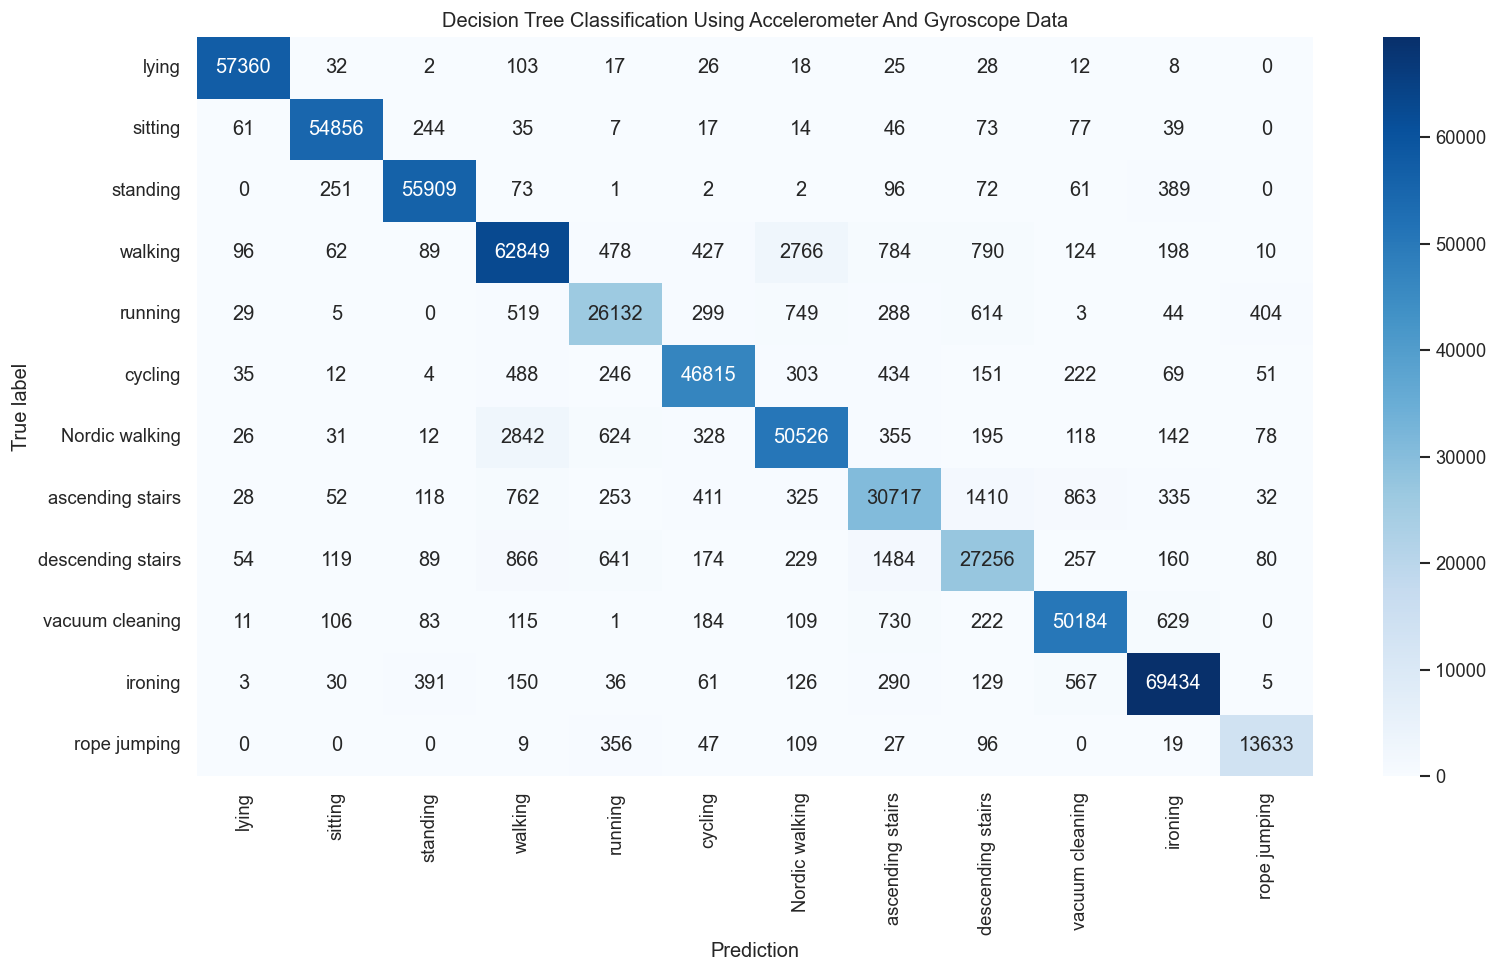

In [88]:
plot_confusion_matrix(tclf,X_test_dt,y_test_dt,"Decision Tree Classification",is_ml=True)

# Outcomes <a class="anchor" id="eight-bullet"></a>

The objective set at the beginning of this report, which was to obtain a reliable model to estimate the amount of physical activity and the type of physical activity carried out by a subject, was achieved. We started by cleaning the data and took the decision to fill in the empty values of heart rate with the value immediately below, since these empty values correspond to the waiting time between one measurement and the next.

We then performed the exploratory analysis and found that there was a clear trend of higher heart rate with higher intensity of activity, which was verified by performing our hypothesis test and obtaining a zero p-value for the z-test.
The correlation matrix within the exploratory analysis also revealed that there was a correlation between heart rate and some IMU measurement variables. The variables that best explain heart rate were used as input for our models. The variables chosen were as follows:
'chestMagne3','handTemperature', 'chestMagne2', 'chestAcc16_3',' chestAcc6_3', 'ankleAcc6_1'.

Considering this, we proceeded to perform the model to predict heart rate values, first a multivariable linear regression model was tested, which gave us an RMS value of 20.53 and a pearson correlation coefficient of 0.42. This is not a good model, but it is not discardable either, since it predicts a large part of the values and maintains the trend as can be seen in the graph of actual vs. predicted values; however, it falls out of the range in the medium intensity values. We tested a cross validation on this model and found that the model is quite stable and does not depend on the selection of the training and test sample.
Our second model for predicting heart rate values was the random forest regression model, which is originally a classification model, but was adapted to perform regression. With this model we performed 2 tests, the first with the parameter n_stimators=10 and max_depth=3 and the second test with n_stimators=100 and max_depth without limit. This gave us a mean absolute error (mae) of 9.36 and accuracy 91.25% for the first test and mean absolute error (mae) of 0.29 and accuracy 99.72% for the second test.
Although it is not possible to find a metric that allows us to compare the linear regression model with the random forest model, when plotting the predicted values vs. real values we observed a clear improvement with respect to the linear regression model in the second randomforest test, which obtained accuracy 99.72%.

As the second part of the report, we proceeded to perform the model to predict categories, starting with K-means clustering with PCA-reduced data, followed by the K-Nearest Neighbors model and finally, a decision tree model. 

For the k-means algorithm, when plotting the actual values and the values that the algorithm clustered, we found clear differences, which confirms that the k-means algorithm is not appropriate to perform classification of categorical values and should be discarded, this happens because k-means only works when the mean is defined, categorical data cannot calculate the mean value. 
Howerver, the K-Nearest Neighbors and Classification model with decision trees algorithms, classified the type of activity with high accuracy, with an accuracy of 96.18% for KNN and 94.66% for decision trees.

# References <a class="anchor" id="nine-bullet"></a>

Multiple Linear Regression in R. (2018, 10 marzo). Articles - STHDA. http://www.sthda.com/english/articles/40-regression-analysis/168-multiple-linear-regression-in-r/

Kumar, A. (2022, May 31). K-Fold Cross Validation - Python Example. Data Analytics. https://vitalflux.com/k-fold-cross-validation-python-example/

Bhalla, D. (n.d.). A complete guide to Random Forest in R. ListenData. https://www.listendata.com/2014/11/random-forest-with-r.html

Logunova, I. (2022, September 20). K-Nearest Neighbors Algorithm for ML. Serokell Software Development Company. https://serokell.io/blog/knn-algorithm-in-ml

Nik (2022). Decision Tree Classifier with Sklearn in Python https://datagy.io/sklearn-decision-tree-classifier/.

Bento, C. (2022, May 31). Decision Tree Classifier explained in real-life: picking a vacation destination. Medium. https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575

